## Importing libraries

In [141]:
import cobra
from cobra.core import Metabolite, Reaction, Model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import importlib
import matplotlib.lines as mlines
import matplotlib
# import d3flux

In [142]:
from cobra.flux_analysis import flux_variability_analysis
import plotly.io as pio
import plotly.express as px
from escher import Builder

In [143]:
import Utils_Cobrapy
importlib.reload(Utils_Cobrapy)

<module 'Utils_Cobrapy' from 'c:\\Users\\home\\Desktop\\Fac\\Master bio-info\\M2\\Stage\\2023\\mitocore_calpainopathy\\Utils_Cobrapy.py'>

## Loading sbml model

In [144]:
# Loading one model for each condition

mitocore_mouse25=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse65=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse85=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse100=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse85_bis=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse100_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")
mitocore_mouse_to_update=cobra.io.read_sbml_model("Models/Mitocore_mouse.xml")

### Choosing the solver

In [145]:
models_to_use = [mitocore_mouse25, mitocore_mouse65, mitocore_mouse85, mitocore_mouse100, mitocore_mouse100_calpain, mitocore_mouse_to_update, mitocore_mouse85_bis]

for model in models_to_use:
    model.solver = 'glpk'

In [146]:
mitocore_mouse25

Name,S1SBMLmodel
Memory address,0x02b52e9c0df0
Number of metabolites,441
Number of reactions,554
Number of groups,96
Objective expression,1.0*OF_ATP_MitoCore - 1.0*OF_ATP_MitoCore_reverse_653d9
Compartments,"Cytosol, Mitochondrion, External"


## Variables

In [147]:
dict_results_voie_metabolique=dict()
dict_results_accoa=dict()
dict_results_atp=dict()

## Functions for data visualisation

In [148]:
def build_dataframe(model, soluce, threshold_down, threshold_up, hide_transport=True, from_list = False, pathways_list = ['TCA cycle']):
    df_percent = soluce.to_frame()
    subsystems = []

    for index, row in df_percent.iterrows():
        notes = model.reactions.get_by_id(index).notes
        if notes != {}:
            subsystems.append(notes['SUBSYSTEM'])
        else:
            subsystems.append('unknown')

    df_percent['Subsystems'] = subsystems
    df_percent['Reactions'] = df_percent.index
    df_percent_sort = df_percent.loc[df_percent['fluxes'] > threshold_down]
    df_percent_sort = df_percent_sort.loc[df_percent_sort['fluxes'] < threshold_up]
    # if not from_list:
    df_percent_sort = df_percent_sort.loc[df_percent_sort['Subsystems'] != 'unknown']

    if hide_transport:
        row2drop = []
        subsystems_to_hide = ['Electron transport chain', 'TCA cycle', 'Boundary conditions - core', 'Mitochondrial transport - diffusion / artificial', 'Mitochondrial transporters - characterised', 'Objective Function - ATP']
        # subsystems_to_hide = ['Electron transport chain', 'Boundary conditions - core', 'Mitochondrial transport - diffusion / artificial']
        
        for index, row in df_percent_sort.iterrows():
            if any(x in row['Subsystems'] for x in subsystems_to_hide):
                row2drop.append(index)

        df_percent_sort = df_percent_sort.drop(row2drop)
    
    if from_list:
        row2drop = []
        for index, row in df_percent_sort.iterrows():
            if row['Subsystems'] not in pathways_list:
                row2drop.append(index)

        df_percent_sort = df_percent_sort.drop(row2drop)       

    return df_percent_sort

In [149]:
def build_dataframe_visual(model, soluce, fva = False):

    if fva:
        df_percent = soluce
    else:
        df_percent = soluce.to_frame()

    subsystems = []

    for index, row in df_percent.iterrows():
        notes = model.reactions.get_by_id(index).notes
        if notes != {}:
            subsystems.append(notes['SUBSYSTEM'])
        else:
            subsystems.append('unknown')

    df_percent['Subsystems'] = subsystems
    df_percent['Reactions'] = df_percent.index

    if fva:
        df_percent = df_percent.sort_values(by=['Subsystems'])
    else:
        df_percent = df_percent.sort_values(by=['Subsystems', 'fluxes'])

    # print(df_percent.to_markdown())
    return df_percent

In [150]:
def display_treemap(dataframe, name):
  fig = px.treemap(dataframe,
    path = [px.Constant('Cell'),'Subsystems', 'Reactions'],
    values = 'fluxes',
    color = 'fluxes',
    color_continuous_scale=px.colors.diverging.RdBu[::-1],
    # color_continuous_scale=px.colors.diverging.curl,
    # color_continuous_scale=px.colors.cyclical.HSV,
    # width = 1400,
    # height = 900
    width = 1000,
    height = 900
  )
  fig.update_traces(textinfo = "label+value",textposition="middle center",hovertemplate='Pathway or enzyme=%{label}<br>Flux=%{value}<br>Percentage=.%{percent entry}<extra></extra>')
  # fig.update_traces(hovertext=['fluxes'])

  
  # Changement du layout
  fig.update_layout(
    {'font_color': "white",
    'plot_bgcolor': 'rgba(0, 0, 0, 100)',
    'paper_bgcolor': '#2e2d2d'},
    title = f"Treemaps of metabolic pathways for {name}% physical intensity",
    title_x=0.5,
    title_y=0.97
    )

  fig.show()

In [151]:
def print_reactions_from_met(model, metabolite, solution, notNull = True):
    reactions = model.metabolites.get_by_id(metabolite).reactions
    for r in reactions:
        flux = solution.to_frame().loc[r.id]
        if notNull:
            if flux['fluxes'] != 0:
                print(r)
                print(solution.to_frame().loc[r.id])
                print('--------')
        else:
            print(r)
            print(solution.to_frame().loc[r.id])
            print('--------')

In [152]:
def get_reactions_from_subsys(model, dt_fluxes, list_of_subsys):
    for subsys in list_of_subsys:
        print(f"\n------ Reactions from {subsys} -------\n")
        df_subsys = dt_fluxes.loc[dt_fluxes['Subsystems'] == subsys]
        for index, row in df_subsys.iterrows():
            print(model.reactions.get_by_id(index))
            print(f"{row['fluxes']}\n")

In [153]:
def get_alternative_pathways(fva_dt):
    essential_react = []
    alternative = []

    for index, row in fva_dt.iterrows():
        if row['minimum'] != row['maximum']:
            alternative.append(index)
        else: # if row['minimum'] > 0:
            essential_react.append(index)

    return alternative

In [154]:
def get_reactions_to_check(all_fluxes_dt, alternative, subsys):
    reaction_to_check = []

    for react_id in alternative:
        reaction = all_fluxes_dt.loc[react_id]
        if reaction['fluxes'] == 0 and reaction['Subsystems'] == subsys:
            # print(reaction['Subsystems'])
            reaction_to_check.append(react_id)

    return reaction_to_check

In [155]:
def print_alternative_reactions(list_id, fva_dt):
    for react_id in list_id:
        print(fva_dt.loc[react_id])
        print("---------------------------")

In [156]:
# dict_tot = {'25':0,'65':0,'85':0, '100':0} 
# dict_prop={'25':{},'65':{},'85':{}, '100':{}}
def build_dict_proportion(dict_pathway, dict_tot={'25':0,'65':0,'85':0}, dict_prop={'25':{},'65':{},'85':{}}):
    for intensity in dict_pathway:
        # print(intensity)
        for pathway in dict_pathway[intensity]:
            # print(pathway)
            dict_tot[intensity] += dict_pathway[intensity][pathway]
            # print(dict_tot[intensity])
    
    for intensity in dict_pathway:
        for pathway in dict_pathway[intensity]:
            dict_prop[intensity][pathway] = dict_pathway[intensity][pathway] / dict_tot[intensity]
    
    return dict_prop

In [157]:
def get_key_fluxes(solution, list_enzyme = ["FBA", "PDHm", "LDH_L", "CSm", "r0722", "r0732", "OF_ATP_MitoCore", "O2t"]):
    list_key = []
    df_sol = solution.to_frame()

    for enzyme in list_enzyme:
        list_key.append(df_sol.loc[enzyme]['fluxes'])
    
    return list_key

In [158]:
def create_df_key_fluxes(dict_sol, list_enzyme = ["FBA", "PDHm", "LDH_L", "CSm", "r0722", "r0732", "OF_ATP_MitoCore", "O2t"]):
    df_key = pd.DataFrame(index=list_enzyme)
    for sol in dict_sol:
        list_key = get_key_fluxes(dict_sol[sol], list_enzyme)
        df_key[sol] = list_key
    
    return df_key

In [159]:
def create_model_calpain(model, ub100, ub85, csv_file):

    dict_reg = {'Warning': 0.5, 'Baisse': 0.5, 'Hausse':2}
    upperbounds_before = []
    upperbounds_after = []
    lowerbounds_after = []
    fva_min = []
    fva_max = []
    regulation = []
    index = []
    df_upperbounds = pd.DataFrame()

    csv = pd.read_csv(csv_file, ',')
    reaction_to_regulate = csv['id_reaction'].to_list()

    for reaction in reaction_to_regulate:
        reg = csv.loc[csv['id_reaction'] == reaction].iloc[0]['Regulation']
        if ';' in reaction:
            reaction_list = reaction.split(';')
            for r in reaction_list:
                index.append(r)
                upperbounds_before.append(model.reactions.get_by_id(r).upper_bound)
                if ub100.loc[r]['Subsystems'] == 'FA metabolism':
                    if reg in dict_reg:
                        factor = dict_reg[reg]
                    else:
                        factor = float(reg)
                    # model.reactions.get_by_id(r).upper_bound = max((ub85.loc[r]['maximum']*factor), 0)
                    bound = ub85.loc[r]['maximum']*factor
                    if bound <= 0:
                        bound = ub85.loc[r]['minimum']*factor
                    fva_min.append(ub85.loc[r]['minimum'])
                    fva_max.append(ub85.loc[r]['maximum'])
                else:
                    if reg in dict_reg:
                        factor = dict_reg[reg]
                    else:
                        factor = float(reg)
                    # model.reactions.get_by_id(r).upper_bound = max((ub100.loc[r]['maximum']*factor), 0)
                    bound = ub100.loc[r]['maximum']*factor
                    if bound <= 0:
                        bound = ub100.loc[r]['minimum']*factor
                    fva_min.append(ub100.loc[r]['minimum'])
                    fva_max.append(ub100.loc[r]['maximum'])
                regulation.append(factor)
                if bound <= 0:
                    model.reactions.get_by_id(r).lower_bound = bound
                    lowerbounds_after.append(model.reactions.get_by_id(r).lower_bound)
                    upperbounds_after.append(model.reactions.get_by_id(r).upper_bound)
                else:
                    model.reactions.get_by_id(r).upper_bound = bound
                    lowerbounds_after.append(model.reactions.get_by_id(r).lower_bound)
                    upperbounds_after.append(model.reactions.get_by_id(r).upper_bound)
        else:
            index.append(reaction)
            upperbounds_before.append(model.reactions.get_by_id(reaction).upper_bound)
            if ub100.loc[reaction]['Subsystems'] == 'FA metabolism':
                if reg in dict_reg:
                    factor = dict_reg[reg]
                else:
                    factor = float(reg)
                # model.reactions.get_by_id(reaction).upper_bound = max((ub85.loc[reaction]['maximum']*factor), 0)
                bound = ub85.loc[reaction]['maximum']*factor
                if bound <= 0:
                    bound = ub85.loc[reaction]['minimum']*factor
                fva_min.append(ub85.loc[reaction]['minimum'])
                fva_max.append(ub85.loc[reaction]['maximum'])
            else:
                if reg in dict_reg:
                    factor = dict_reg[reg]
                else:
                    factor = float(reg)
                # model.reactions.get_by_id(reaction).upper_bound = max((ub100.loc[reaction]['maximum']*factor), 0)
                bound = ub100.loc[reaction]['maximum']*factor
                if bound <= 0:
                    bound = ub100.loc[reaction]['minimum']*factor
                fva_min.append(ub100.loc[reaction]['minimum'])
                fva_max.append(ub100.loc[reaction]['maximum'])
            regulation.append(factor)
            if bound <= 0:
                model.reactions.get_by_id(reaction).lower_bound = bound
                lowerbounds_after.append(model.reactions.get_by_id(reaction).lower_bound)
                upperbounds_after.append(model.reactions.get_by_id(reaction).upper_bound)
            else:
                model.reactions.get_by_id(reaction).upper_bound = bound
                lowerbounds_after.append(model.reactions.get_by_id(reaction).lower_bound)
                upperbounds_after.append(model.reactions.get_by_id(reaction).upper_bound)

    df_upperbounds['reactions'] = index
    df_upperbounds['upperbounds_wt'] = upperbounds_before
    df_upperbounds['fva_min'] = fva_min
    df_upperbounds['fva_max'] = fva_max
    df_upperbounds['regulation'] = regulation
    df_upperbounds['lowerbounds_calpain'] = lowerbounds_after
    df_upperbounds['upperbounds_calpain'] = upperbounds_after
    
    # cobra.io.write_sbml_model(model, filename="Models/Mitocore_mouse_calpain.xml")

    return model, df_upperbounds

In [160]:
csv = pd.read_csv('tab_regulation.csv', ',')
print(csv['id_reaction'].to_list())

['ICDHy', 'FBP', 'ALCD2if', 'AKGDm', 'MTHFD2m;MTHFDm', 'CSm', 'r0722;r0726;r0730;r0733;HACD1m;HACD9m', 'CV_MitoCore', 'SPODMm', 'GTHP', 'LDH_L;MCLOR', 'BDHm', 'HtmB_MitoCore', 'FBA', 'ACS;ACCOALm;ACSm', 'CIV_MitoCore']


C:\Users\home\AppData\Local\Temp\ipykernel_16648\3877323663.py:1: FutureWarning:

In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.



In [161]:
def create_flux_plot(dict_sol_fva, list_enzyme = ["FBA", "PDHm", "LDH_L", "CSm", "r0722", "r0732", "OF_ATP_MitoCore", "O2t"]):
    df = pd.DataFrame(columns=['enzymes', 'intensity', 'fluxes', 'fva_min', 'fva_max'])
    # enzymes = []
    # intensities = []
    # fluxes = []
    # fva_min = []
    # fva_max = []
    row = 0

    for enzyme in list_enzyme:
        for intensity in dict_sol_fva:
            if '25' in intensity:
                percent = '25%'
            elif '65' in intensity:
                percent = '65%'
            elif '85' in intensity:
                percent = '85%'
            else:
                percent = '100%'
            df.loc[row] = [enzyme, percent, dict_sol_fva[intensity][0].to_frame().loc[enzyme]['fluxes'], dict_sol_fva[intensity][1].loc[enzyme]['minimum'], dict_sol_fva[intensity][1].loc[enzyme]['maximum']]
            row += 1
            # enzymes.append(enzyme)
            # intensities.append(intensity)
            # fluxes.append(dict_sol_fva[intensity][0].to_frame().loc[enzyme]['fluxes'])
            # fva_min.append(dict_sol_fva[intensity][1].loc[enzyme]['minimum'])
            # fva_max.append(dict_sol_fva[intensity][1].loc[enzyme]['maximum'])
    
    # df['enzymes'] = enzymes
    # df['intensities'] = intensities
    # df['fluxes'] = fluxes
    # df['fva_min'] = fva_min
    # df['fva_max'] = fva_max

    return df

## Options

In [162]:
VO2max_25 = True
VO2max_65 = True
VO2max_85 = True
VO2max_100 = True

mouse_WT = True
mouse_calpain = True

## Mice model WT

In [163]:
# mitocore_mouse65.reactions.PDHm.lower_bound = 0.2
# # mitocore_mouse25.reactions.LDH_L.upper_bound = -0.01
# mitocore_mouse65.reactions.LDH_L.upper_bound = -0.112
# mitocore_mouse85.reactions.LDH_L.upper_bound = -0.294
# mitocore_mouse100.reactions.LDH_L.upper_bound = -0.4
# mitocore_mouse25.reactions.r0722.lower_bound = 0.2
# mitocore_mouse25.reactions.r0942b_MitoCore.lower_bound = -1000
# mitocore_mouse65.reactions.r0942b_MitoCore.lower_bound = -1000
# mitocore_mouse85.reactions.r0942b_MitoCore.lower_bound = -1000
# mitocore_mouse100.reactions.LDH_L.lower_bound = -0.15
# mitocore_mouse100.reactions.FBA.upper_bound = 1.7

In [164]:
if VO2max_25 and mouse_WT:
    # mitocore_mouse25.reactions.r0732.bounds = (0.12,1000)
    output25=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse25,O2_upper_bound=3.7,glucose_upper_bound=0.03,
        FA_upper_bound=0.1,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=14.6, FVA=True)

if VO2max_65 and mouse_WT:
    # mitocore_mouse.reactions.r0732.bounds = (0.75,1000)
    output65=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse65,O2_upper_bound=7.9,glucose_upper_bound=0.13,
        FA_upper_bound=0.27,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=36.52, FVA=True)

if VO2max_85 and mouse_WT:
    # mitocore_mouse.reactions.r0732.bounds = (1,1000)
    output85=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse85,O2_upper_bound=11.1,glucose_upper_bound=0.6,
        FA_upper_bound=0.3,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=54.8, FVA=True)
    
if VO2max_100 and mouse_WT:
    output100=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse100,O2_upper_bound=14,glucose_upper_bound=2,
        FA_upper_bound=0.08,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=75, FVA=True)

In [165]:
glc_25 = [0.03, 0.6, 0.1, 0.13, 0.2, 0.6, 1.2, 2]
dict_fluxes = {"FBA": {}, "PDHm": {}, "LDH_L": {}, "CSm": {}, "r0722": {}, "r0732": {}, "OF_ATP_MitoCore": {}, "O2t": {}}

for glc in glc_25:
    print(glc)
    output=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse25,O2_upper_bound=3.7,glucose_upper_bound=glc,
        FA_upper_bound=0.1,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=14.6, FVA=True)
    
    for enzyme in dict_fluxes:
        dict_fluxes[enzyme][glc] = output[3].fluxes.loc[enzyme]

0.03
0.6
0.1
0.13
0.2
0.6
1.2
2


In [166]:
solution25 = output25[3]
solution65 = output65[3]
solution85 = output85[3]
solution100 = output100[3]

In [167]:
f = "CSm"
solution25.fluxes.loc[f]

1.104578304597701

In [168]:
mitocore_mouse100.reactions.LDH_L.lower_bound

-1000.0

### Key fluxes

In [169]:
key_reactions = create_df_key_fluxes({'wt_25': solution25, 'wt_65': solution65, 'wt_85': solution85, 'wt_100': solution100})
key_reactions

,wt_25,wt_65,wt_85,wt_100
FBA,0.030000,0.1300,0.600000,2.000000
PDHm,0.110500,0.2010,1.304833,3.846167
LDH_L,-0.075000,-0.1040,-0.141167,-0.399833
CSm,1.104578,2.8014,3.768833,4.694167
r0722,0.100000,0.2700,0.300000,0.080000
r0732,0.100000,0.2700,0.300000,0.080000
OF_ATP_MitoCore,14.600000,36.5200,54.800000,75.000000
O2t,3.311407,7.9000,11.100000,14.000000


In [170]:
# print(key_reactions.to_latex())

In [171]:
solution25_dt = solution25.to_frame()
solution65_dt = solution65.to_frame()
solution85_dt = solution85.to_frame()
solution100_dt = solution100.to_frame()

In [172]:
mitocore_mouse100

Name,S1SBMLmodel
Memory address,0x02b530862f70
Number of metabolites,441
Number of reactions,554
Number of groups,96
Objective expression,1.0*OF_ATP_MitoCore - 1.0*OF_ATP_MitoCore_reverse_653d9
Compartments,"Cytosol, Mitochondrion, External"


### Building dataframes

#### Dataframes for treemaps

In [173]:
dt25 = build_dataframe(mitocore_mouse25, solution25, 0, 18)
dt65 = build_dataframe(mitocore_mouse65, solution65, 0, 18)
dt85 = build_dataframe(mitocore_mouse85, solution85, 0, 18)
dt100 = build_dataframe(mitocore_mouse100, solution100, 0, 18)

#### Dataframes of all fluxes

In [174]:
all_fluxes_25 = build_dataframe_visual(mitocore_mouse25, solution25)
print(all_fluxes_25.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [175]:
all_fluxes_65 = build_dataframe_visual(mitocore_mouse65, solution65)
print(all_fluxes_65.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [176]:
all_fluxes_85 = build_dataframe_visual(mitocore_mouse85, solution85)
print(all_fluxes_85.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [177]:
all_fluxes_100 = build_dataframe_visual(mitocore_mouse100, solution100)
print(all_fluxes_100.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

### Flux Variability Analysis

In [178]:
fva25 = output25[5]
fva65 = output65[5]
fva85 = output85[5]
fva100 = output100[5]

In [179]:
# alternative25 = get_alternative_pathways(fva25)
# alternative65 = get_alternative_pathways(fva65)
# alternative85 = get_alternative_pathways(fva85)
# alternative100 = get_alternative_pathways(fva100)

In [180]:
# reaction_to_check_25 = get_reactions_to_check(all_fluxes_25, alternative25, 'Carnitine shuttle')
# reaction_to_check_65 = get_reactions_to_check(all_fluxes_65, alternative65, 'FA metabolism')
# reaction_to_check_85 = get_reactions_to_check(all_fluxes_85, alternative85, 'FA metabolism')
# reaction_to_check_100 = get_reactions_to_check(all_fluxes_100, alternative100, 'FA metabolism')

In [181]:
df = build_dataframe_visual(mitocore_mouse100, fva100, True)
print(df.to_markdown())

|                          |         minimum |        maximum | Subsystems                                                       | Reactions                |
|:-------------------------|----------------:|---------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |     0           |    0.718361    | Acetate production                                               | ACOAHi                   |
| ACSm                     |     0           |    6.54605e-35 | Alcohol metabolism                                               | ACSm                     |
| ACS                      |     0           |    0.715383    | Alcohol metabolism                                               | ACS                      |
| ALDD2x                   |     0           |   -7.97396e-35 | Alcohol metabolism                                               | ALDD2x                   |
| ALDD2xm                  |     0           |   -1.

### Building treemaps

In [182]:
if mouse_WT:
    display_treemap(dt25, '25')
    display_treemap(dt65, '65')
    display_treemap(dt85, '85')
    display_treemap(dt100, '100')

### Relative contributions of pathways during exercise

{'glycolysis': 0.06999999999999972, 'beta oxydation': 0.1, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.004}
{'glycolysis': 0.27, 'beta oxydation': 0.27, 'ketone bodies': 0.048, 'leucine degradation': 0.016, 'isoleucine degradation': 0.004}
{'glycolysis': 1.21, 'beta oxydation': 0.3, 'ketone bodies': 0.0, 'leucine degradation': 3.885780586188048e-16, 'isoleucine degradation': 0.004}
{'glycolysis': 4.01, 'beta oxydation': 0.08, 'ketone bodies': 0.048, 'leucine degradation': 0.016, 'isoleucine degradation': 0.004}
['25%' '65%' '85%' '100%']


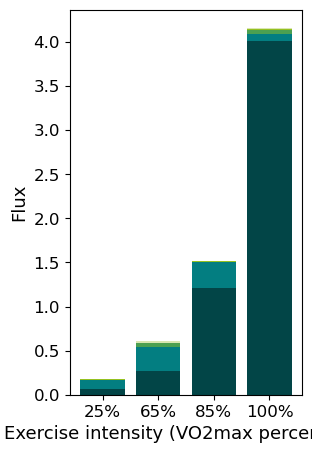

{'25%': {'glycolysis': 0.06999999999999972,
  'beta oxydation': 0.1,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.004},
 '65%': {'glycolysis': 0.27,
  'beta oxydation': 0.27,
  'ketone bodies': 0.048,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.004},
 '85%': {'glycolysis': 1.21,
  'beta oxydation': 0.3,
  'ketone bodies': 0.0,
  'leucine degradation': 3.885780586188048e-16,
  'isoleucine degradation': 0.004},
 '100%': {'glycolysis': 4.01,
  'beta oxydation': 0.08,
  'ketone bodies': 0.048,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.004}}

In [183]:
dict_results_voie_metabolique["25%"]=output25[1]
dict_results_voie_metabolique["65%"]=output65[1]
dict_results_voie_metabolique["85%"]=output85[1]
dict_results_voie_metabolique["100%"]=output100[1]
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_voie_metabolique,"plot_mouse_voie_metabolique.png")

In [184]:
dict_results_voie_metabolique_proportion = build_dict_proportion(dict_pathway=dict_results_voie_metabolique, dict_tot={'25%':0,'65%':0,'85%':0, '100%':0}, dict_prop={'25%':{},'65%':{},'85%':{}, '100%':{}})

{'glycolysis': 0.40229885057471165, 'beta oxydation': 0.5747126436781619, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.022988505747126475}
{'glycolysis': 0.444078947368421, 'beta oxydation': 0.444078947368421, 'ketone bodies': 0.07894736842105263, 'leucine degradation': 0.026315789473684206, 'isoleucine degradation': 0.006578947368421051}
{'glycolysis': 0.7992073976221926, 'beta oxydation': 0.1981505944517833, 'ketone bodies': 0.0, 'leucine degradation': 2.5665657768745355e-16, 'isoleucine degradation': 0.0026420079260237772}
{'glycolysis': 0.9644059644059645, 'beta oxydation': 0.01924001924001924, 'ketone bodies': 0.011544011544011546, 'leucine degradation': 0.0038480038480038486, 'isoleucine degradation': 0.0009620009620009621}
['25%' '65%' '85%' '100%']


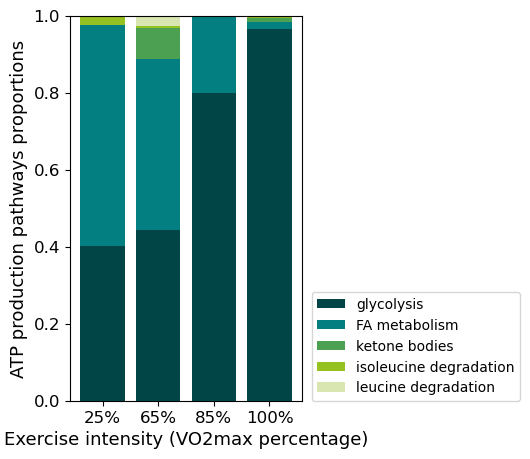

{'25%': {'glycolysis': 0.40229885057471165,
  'beta oxydation': 0.5747126436781619,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.022988505747126475},
 '65%': {'glycolysis': 0.444078947368421,
  'beta oxydation': 0.444078947368421,
  'ketone bodies': 0.07894736842105263,
  'leucine degradation': 0.026315789473684206,
  'isoleucine degradation': 0.006578947368421051},
 '85%': {'glycolysis': 0.7992073976221926,
  'beta oxydation': 0.1981505944517833,
  'ketone bodies': 0.0,
  'leucine degradation': 2.5665657768745355e-16,
  'isoleucine degradation': 0.0026420079260237772},
 '100%': {'glycolysis': 0.9644059644059645,
  'beta oxydation': 0.01924001924001924,
  'ketone bodies': 0.011544011544011546,
  'leucine degradation': 0.0038480038480038486,
  'isoleucine degradation': 0.0009620009620009621}}

In [185]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_voie_metabolique_proportion,"plot_mouse_voie_metabolique_proportion.png", prop=True)

{'Isoleucine degradation': 0.38, 'FA and ketone body metabolism / Ketogenesis': 41.63, 'FA metabolism': 56.940000000000005, 'TCA cycle': 1.04}
{'Isoleucine degradation': 0.15, 'FA and ketone body metabolism / Ketogenesis': 34.86, 'FA metabolism': 61.13999999999999, 'TCA cycle': 3.88}
{'Isoleucine degradation': 0.1, 'FA and ketone body metabolism / Ketogenesis': 25.62, 'FA metabolism': 46.86, 'TCA cycle': 27.41}
{'Isoleucine degradation': 0.09, 'FA and ketone body metabolism / Ketogenesis': 6.73, 'FA metabolism': 10.2, 'TCA cycle': 82.95}
['25' '65' '85' '100']


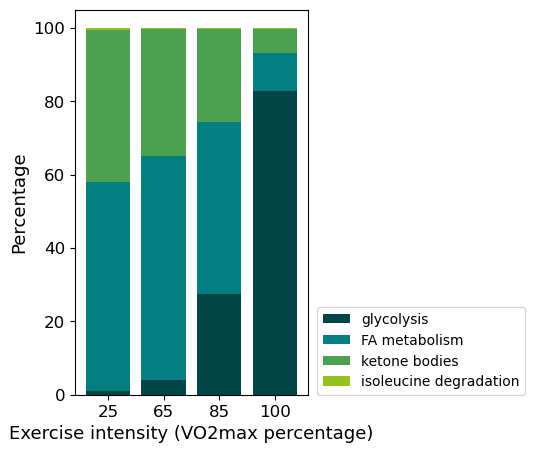

{'25': {'Isoleucine degradation': 0.38,
  'FA and ketone body metabolism / Ketogenesis': 41.63,
  'FA metabolism': 56.940000000000005,
  'TCA cycle': 1.04},
 '65': {'Isoleucine degradation': 0.15,
  'FA and ketone body metabolism / Ketogenesis': 34.86,
  'FA metabolism': 61.13999999999999,
  'TCA cycle': 3.88},
 '85': {'Isoleucine degradation': 0.1,
  'FA and ketone body metabolism / Ketogenesis': 25.62,
  'FA metabolism': 46.86,
  'TCA cycle': 27.41},
 '100': {'Isoleucine degradation': 0.09,
  'FA and ketone body metabolism / Ketogenesis': 6.73,
  'FA metabolism': 10.2,
  'TCA cycle': 82.95}}

In [186]:
dict_results_accoa["25"]=output25[0]
dict_results_accoa["65"]=output65[0]
dict_results_accoa["85"]=output85[0]
dict_results_accoa["100"]=output100[0]

Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_accoa,"plot_mouse_accoa.png",accoa=True)

In [187]:
key_reactions_plot = key_reactions.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

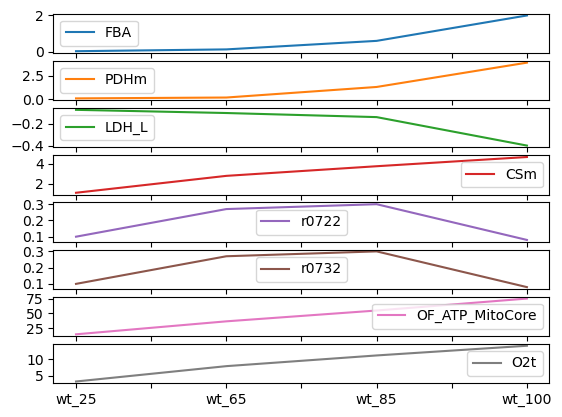

In [188]:
key_reactions_plot.plot(subplots=True)

In [189]:
df_wt_plot = create_flux_plot({'wt_25': [solution25, fva25], 'wt_65': [solution65, fva65], 'wt_85': [solution85, fva85], 'wt_100': [solution100, fva100]})

In [190]:
df_wt_plot

,enzymes,intensity,fluxes,fva_min,fva_max
0,FBA,25%,0.030000,0.000000,0.030000
1,FBA,65%,0.130000,0.000000,0.130000
2,FBA,85%,0.600000,0.236463,0.600000
3,FBA,100%,2.000000,1.656903,2.000000
4,PDHm,25%,0.110500,0.000000,0.681340
5,PDHm,65%,0.201000,0.000000,0.791369
6,PDHm,85%,1.304833,0.714650,1.653818
7,PDHm,100%,3.846167,3.479930,4.395126
8,LDH_L,25%,-0.075000,-0.472196,0.000000
9,LDH_L,65%,-0.104000,-0.572137,0.000000


C:\Users\home\AppData\Local\Temp\ipykernel_16648\867705675.py:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



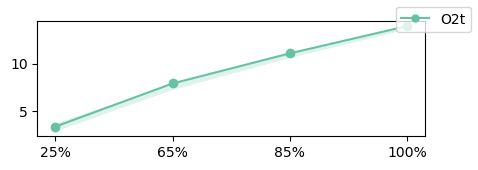

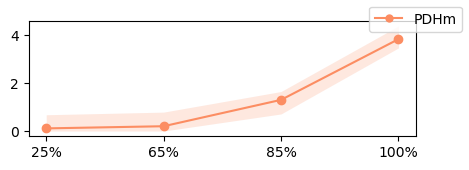

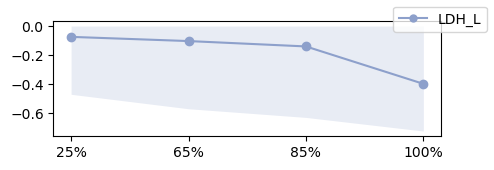

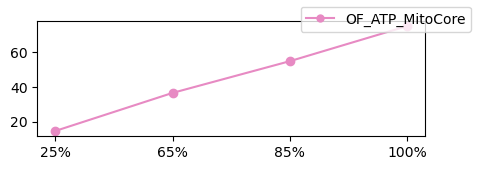

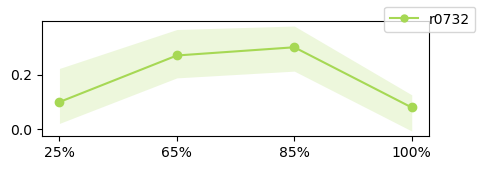

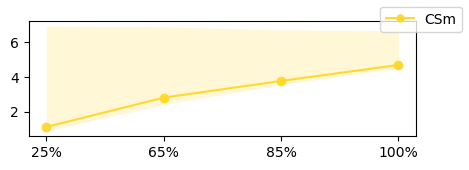

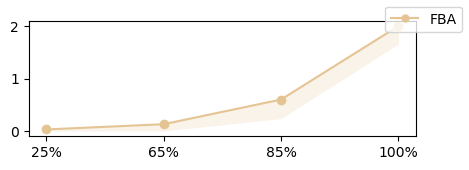

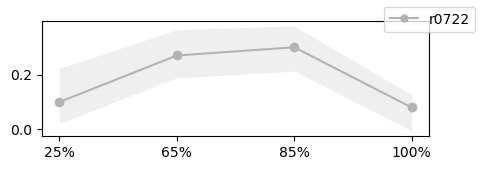

In [191]:
cmap = matplotlib.cm.get_cmap('Set2')
count = 0

for enzyme in list(set(df_wt_plot['enzymes'].to_list())):
    df_enz = df_wt_plot.loc[df_wt_plot['enzymes'] == enzyme]
    fig, ax = plt.subplots(1, 1, figsize=(5, 1.5), sharey=True)
    ax.scatter(df_enz['intensity'], df_enz['fluxes'], color=cmap(count))
    ax.plot(df_enz['intensity'], df_enz['fluxes'], color=cmap(count))
    ax.fill_between(df_enz['intensity'], df_enz['fva_min'], df_enz['fva_max'], alpha=0.2, color=cmap(count), linewidth=0)
    leg = mlines.Line2D([], [], color=cmap(count), marker='.', markersize=10, label=enzyme, ls='-')
    fig.legend(handles=[leg])
    count += 1

## Mice model Calpainopathy

In [192]:
upperbounds_calpainopathy100 = build_dataframe_visual(mitocore_mouse100, fva100, True)

In [193]:
model_bis, df_bounds = create_model_calpain(mitocore_mouse_to_update,upperbounds_calpainopathy100, fva85, 'tab_regulation.csv')

C:\Users\home\AppData\Local\Temp\ipykernel_16648\812323628.py:13: FutureWarning:

In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.



### Calpain bounds

In [194]:
df_bounds = df_bounds.set_index('reactions')

In [195]:
df_bounds_negative = df_bounds.loc[df_bounds['fva_max'] <= 0]
df_bounds_negative

,upperbounds_wt,fva_min,fva_max,regulation,lowerbounds_calpain,upperbounds_calpain
reactions,,,,,,
FBP,0.0,0.000000,0.000000e+00,3.271608,0.000000,0.0
ALCD2if,1000.0,0.000000,0.000000e+00,4.027822,0.000000,1000.0
MTHFD2m,0.0,-0.008000,0.000000e+00,4.531536,-0.036252,0.0
MTHFDm,0.0,-0.008000,0.000000e+00,4.531536,-0.036252,0.0
HACD1m,1000.0,-0.416517,-2.269152e-01,0.500000,-0.208259,1000.0
LDH_L,1000.0,-0.726278,0.000000e+00,2.830000,-2.055368,1000.0
MCLOR,1000.0,-0.006000,-6.550795e-19,2.830000,-0.016980,1000.0


In [196]:
for reaction, row in df_bounds_negative.iterrows():
    model_bis.reactions.get_by_id(reaction).lower_bound = -1000

In [197]:
cobra.io.write_sbml_model(model_bis, filename="Models/Mitocore_mouse_calpain.xml")

In [198]:
bound = build_dataframe_visual(mitocore_mouse100_calpain,df_bounds, True)

In [199]:
print(bound[['regulation', 'Subsystems']].to_latex())

\begin{tabular}{lrl}
\toprule
{} &  regulation &                                  Subsystems \\
reactions     &             &                                             \\
\midrule
ALCD2if       &    4.027822 &                          Alcohol metabolism \\
ACS           &    2.500000 &                          Alcohol metabolism \\
ACSm          &    2.500000 &                          Alcohol metabolism \\
MCLOR         &    2.830000 &                     Cysteine degradation II \\
CIV\_MitoCore  &    2.320000 &                Electron transport chain CIV \\
CV\_MitoCore   &    0.500000 &                 Electron transport chain CV \\
r0722         &    0.500000 &                               FA metabolism \\
r0726         &    0.500000 &                               FA metabolism \\
r0730         &    0.500000 &                               FA metabolism \\
r0733         &    0.500000 &                               FA metabolism \\
HACD1m        &    0.500000 &                 

C:\Users\home\AppData\Local\Temp\ipykernel_16648\4012819971.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [200]:
mitocore_mouse25_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
mitocore_mouse65_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
mitocore_mouse85_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
mitocore_mouse100bis_calpain=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")

In [201]:
mitocore_mouse100bis_calpain.reactions.FBA.bounds

(-1000.0, 2.66)

In [202]:
models_to_use = [mitocore_mouse25_calpain, mitocore_mouse65_calpain, mitocore_mouse85_calpain, mitocore_mouse100bis_calpain]

for model in models_to_use:
    model.solver = 'glpk'
    for reaction, row in df_bounds_negative.iterrows():
        model.reactions.get_by_id(reaction).lower_bound = row['lowerbounds_calpain']

In [203]:
O2_ub_25 = min(mitocore_mouse25_calpain.reactions.O2t.upper_bound, 3.7)
GLC_ub_25 = min(mitocore_mouse25_calpain.reactions.GLCt1r.upper_bound, 0.03)
FA_ub_25 = min(mitocore_mouse25_calpain.reactions.HDCAtr.upper_bound, 0.1)
ATP_ub_25 = min(mitocore_mouse25_calpain.reactions.OF_ATP_MitoCore.upper_bound, 14.6)

O2_ub_65 = min(mitocore_mouse65_calpain.reactions.O2t.upper_bound, 7.9)
GLC_ub_65 = min(mitocore_mouse65_calpain.reactions.GLCt1r.upper_bound, 0.13)
FA_ub_65 = min(mitocore_mouse65_calpain.reactions.HDCAtr.upper_bound, 0.27)
ATP_ub_65 = min(mitocore_mouse65_calpain.reactions.OF_ATP_MitoCore.upper_bound, 36.52)

O2_ub_85 = min(mitocore_mouse85_calpain.reactions.O2t.upper_bound, 11.1)
GLC_ub_85 = min(mitocore_mouse85_calpain.reactions.GLCt1r.upper_bound, 0.6)
FA_ub_85 = min(mitocore_mouse85_calpain.reactions.HDCAtr.upper_bound, 0.3)
ATP_ub_85 = min(mitocore_mouse85_calpain.reactions.OF_ATP_MitoCore.upper_bound, 54.8)

O2_ub_100 = min(mitocore_mouse100bis_calpain.reactions.O2t.upper_bound, 14)
GLC_ub_100 = 2
FA_ub_100 = min(mitocore_mouse100bis_calpain.reactions.HDCAtr.upper_bound, 0.08)
ATP_ub_100 = min(mitocore_mouse100bis_calpain.reactions.OF_ATP_MitoCore.upper_bound, 75)

In [204]:
# for reaction, row in df_bounds.iterrows():
#     if row['fva_max'] < 0:
#         mitocore_mouse100bis_calpain.reactions.get_by_id(reaction).upper_bound = mitocore_mouse100bis_calpain.reactions.get_by_id(reaction).lower_bound
#     else:
#         # print(reaction)
#         mitocore_mouse100bis_calpain.reactions.get_by_id(reaction).lower_bound = mitocore_mouse100bis_calpain.reactions.get_by_id(reaction).upper_bound

In [205]:
# mitocore_mouse100bis_calpain.reactions.FBA.lower_bound = 2.66
# mitocore_mouse100bis_calpain.reactions.LDH_L.upper_bound = -2.05
# mitocore_mouse25_calpain.reactions.PDHm.lower_bound = solution25.to_frame().loc['PDHm']['fluxes']

In [206]:
mitocore_mouse25_calpain.reactions.LDH_L.upper_bound = solution25.to_frame().loc['LDH_L']['fluxes']
mitocore_mouse65_calpain.reactions.LDH_L.upper_bound = solution65.to_frame().loc['LDH_L']['fluxes']
mitocore_mouse85_calpain.reactions.LDH_L.upper_bound = solution85.to_frame().loc['LDH_L']['fluxes']
mitocore_mouse100bis_calpain.reactions.LDH_L.upper_bound = solution100.to_frame().loc['LDH_L']['fluxes'] * 2.83
# mitocore_mouse100bis_calpain.reactions.FBA.lower_bound = solution100.to_frame().loc['FBA']['fluxes'] * 1.33

In [207]:
solution100.to_frame().loc['FBA']['fluxes']

2.0

In [208]:
# mitocore_mouse25_calpain.reactions.r0122.lower_bound = 0.094

In [209]:
# mitocore_mouse25_calpain.reactions.PFK.lower_bound = 1.01432e-12
# mitocore_mouse25_calpain.reactions.EX_lac_L_e.lower_bound = 3.98396e-12

In [210]:
if VO2max_25:
    output25_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse25_calpain,O2_upper_bound=O2_ub_25,glucose_upper_bound=GLC_ub_25,
        FA_upper_bound=FA_ub_25,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_25, FVA=True)

if VO2max_65:
    # mitocore_mouse.reactions.r0732.bounds = (0.75,1000)
    output65_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse65_calpain,O2_upper_bound=O2_ub_65,glucose_upper_bound=GLC_ub_65,
        FA_upper_bound=FA_ub_65,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_65, FVA=True)

if VO2max_85:
    # mitocore_mouse.reactions.r0732.bounds = (1,1000)
    output85_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse85_calpain,O2_upper_bound=O2_ub_85,glucose_upper_bound=GLC_ub_85,
        FA_upper_bound=FA_ub_85,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_85, FVA=True)

if VO2max_100:
    output100_calpain=Utils_Cobrapy.define_boundary_and_run_model(model=mitocore_mouse100bis_calpain,O2_upper_bound=O2_ub_100,glucose_upper_bound=GLC_ub_100,
        FA_upper_bound=FA_ub_100,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=ATP_ub_100, FVA=True)

In [211]:
# glc_25 = [0.03, 0.6, 0.1, 0.13, 0.2, 0.6, 1.2, 2]
# dict_fluxes = {"FBA": {}, "PDHm": {}, "LDH_L": {}, "CSm": {}, "r0722": {}, "r0732": {}, "OF_ATP_MitoCore": {}, "O2t": {}}

# for glc in glc_25:
#     model=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
#     model.solver = 'glpk'
#     for reaction, row in df_bounds_negative.iterrows():
#         model.reactions.get_by_id(reaction).lower_bound = row['lowerbounds_calpain']

#     print(glc)
    
#     output=Utils_Cobrapy.define_boundary_and_run_model(model=model,O2_upper_bound=3.7,glucose_upper_bound=glc,
#         FA_upper_bound=0.1,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=14.6, FVA=True)
    
#     for enzyme in dict_fluxes:
#         dict_fluxes[enzyme][glc] = output[3].fluxes.loc[enzyme]

In [212]:
# glc_65 = [0.13, 0.2, 0.6, 1.2, 2]
# dict_fluxes_65 = {"FBA": {}, "PDHm": {}, "LDH_L": {}, "CSm": {}, "r0722": {}, "r0732": {}, "OF_ATP_MitoCore": {}, "O2t": {}}

# for glc in glc_65:
#     model=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
#     model.solver = 'glpk'
#     for reaction, row in df_bounds_negative.iterrows():
#         model.reactions.get_by_id(reaction).lower_bound = row['lowerbounds_calpain']

#     print(glc)
    
#     output=Utils_Cobrapy.define_boundary_and_run_model(model=model,O2_upper_bound=7.9,glucose_upper_bound=glc,
#         FA_upper_bound=0.27,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=36.52, FVA=True)
    
#     for enzyme in dict_fluxes:
#         dict_fluxes_65[enzyme][glc] = output[3].fluxes.loc[enzyme]

In [213]:
# glc_85 = [0.6, 1.2, 2, 2.5, 3, 4, 5]
# dict_fluxes_85 = {"FBA": {}, "PDHm": {}, "LDH_L": {}, "CSm": {}, "r0722": {}, "r0732": {}, "OF_ATP_MitoCore": {}, "O2t": {}}

# for glc in glc_85:
#     model=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
#     model.solver = 'glpk'
#     for reaction, row in df_bounds_negative.iterrows():
#         model.reactions.get_by_id(reaction).lower_bound = row['lowerbounds_calpain']

#     print(glc)
    
#     output=Utils_Cobrapy.define_boundary_and_run_model(model=model,O2_upper_bound=11.1,glucose_upper_bound=glc,
#         FA_upper_bound=0.3,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=54.8, FVA=True)
    
#     for enzyme in dict_fluxes:
#         dict_fluxes_85[enzyme][glc] = output[3].fluxes.loc[enzyme]

In [214]:
# glc_100 = [2, 2.5, 3, 3.5, 4]
# dict_fluxes_100 = {"FBA": {}, "PDHm": {}, "LDH_L": {}, "CSm": {}, "r0722": {}, "r0732": {}, "OF_ATP_MitoCore": {}, "O2t": {}}

# for glc in glc_100:
#     model=cobra.io.read_sbml_model("Models/Mitocore_mouse_calpain.xml")
#     model.solver = 'glpk'
#     for reaction, row in df_bounds_negative.iterrows():
#         model.reactions.get_by_id(reaction).lower_bound = row['lowerbounds_calpain']

#     print(glc)
    
#     output=Utils_Cobrapy.define_boundary_and_run_model(model=model,O2_upper_bound=14,glucose_upper_bound=glc,
#         FA_upper_bound=0.08,hydroxybutyrate_upper_bound=0.048,Acetoacetate_upper_bound=0.114, atp_value=75, FVA=True)
    
#     for enzyme in dict_fluxes:
#         dict_fluxes_100[enzyme][glc] = output[3].fluxes.loc[enzyme]

In [215]:
# dict_fluxes_100

In [216]:
# cmap = matplotlib.cm.get_cmap('plasma')
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# leg = []

# plt.subplots_adjust(right=0.8)

# for enzyme in dict_fluxes:
#     count = 0
#     if enzyme != "OF_ATP_MitoCore":
#         for glc in dict_fluxes[enzyme]:
#             ax.scatter(enzyme, dict_fluxes[enzyme][glc], color=cmap(count), alpha=0.5)
#             if enzyme == "FBA":
#                 leg.append(mlines.Line2D([], [], color=cmap(count), marker='.', markersize=10, label=glc, alpha=0.5))
#             count += 40

# fig.legend(handles=leg)
#         # ax.scatter([enzyme for i in dict_fluxes[enzyme].values()], dict_fluxes[enzyme].values())

In [217]:
# dict_fluxes_65

In [218]:
# cmap = matplotlib.cm.get_cmap('plasma')
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# leg = []

# # plt.subplots_adjust(right=0.8)

# for enzyme in dict_fluxes_65:
#     count = 0
#     if enzyme != "OF_ATP_MitoCore":
#         for glc in dict_fluxes_65[enzyme]:
#             ax.scatter(enzyme, dict_fluxes_65[enzyme][glc], color=cmap(count), alpha=0.5, label=glc)
#             # if enzyme == "FBA":
#             #     leg.append(mlines.Line2D([], [], color=cmap(count), marker='.', markersize=10, label=glc, alpha=0.5))
#             count += 60
#         if enzyme == "FBA":
#             fig.legend(loc=(0.18,0.63))

# ax.set_xlabel("Enzymes", fontsize=13)
# ax.set_ylabel("Valeur de flux", fontsize=13)
# plt.title("65% de VO2max", fontsize=15)
# # fig.legend(handles=leg, loc='center right')

In [219]:
# cmap = matplotlib.cm.get_cmap('plasma')
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# leg = []

# # plt.subplots_adjust(right=0.8)

# for enzyme in dict_fluxes_85:
#     count = 0
#     if enzyme != "OF_ATP_MitoCore":
#         for glc in dict_fluxes_85[enzyme]:
#             ax.scatter(enzyme, dict_fluxes_85[enzyme][glc], color=cmap(count), alpha=0.5, label=glc)
#             # if enzyme == "FBA":
#             #     leg.append(mlines.Line2D([], [], color=cmap(count), marker='.', markersize=10, label=glc, alpha=0.5))
#             count += 40
#         if enzyme == "FBA":
#             fig.legend(loc=(0.18,0.52))

# ax.set_xlabel("Enzymes", fontsize=13)
# ax.set_ylabel("Valeur de flux", fontsize=13)
# plt.title("85% de VO2max", fontsize=15)


In [220]:
# cmap = matplotlib.cm.get_cmap('plasma')
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# leg = []

# # plt.subplots_adjust(right=0.8)

# for enzyme in dict_fluxes_100:
#     count = 0
#     if enzyme != "OF_ATP_MitoCore":
#         for glc in dict_fluxes_100[enzyme]:
#             ax.scatter(enzyme, dict_fluxes_100[enzyme][glc], color=cmap(count), alpha=0.6, label=glc)
#             # if enzyme == "FBA":
#             #     leg.append(mlines.Line2D([], [], color=cmap(count), marker='.', markersize=10, label=glc, alpha=0.5))
#             count += 60
#         if enzyme == "FBA":
#             fig.legend(loc=(0.18,0.62))

# # fig.legend(handles=leg)
# ax.set_xlabel("Enzymes", fontsize=13)
# ax.set_ylabel("Valeur de flux", fontsize=13)
# plt.title("100% de VO2max", fontsize=15)

In [221]:
solution25_calpain = output25_calpain[3]
solution65_calpain = output65_calpain[3]
solution85_calpain = output85_calpain[3]
solution100_calpain = output100_calpain[3]

C:\Users\home\AppData\Local\Temp\ipykernel_16648\2236124025.py:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



(0.0, 75.0)

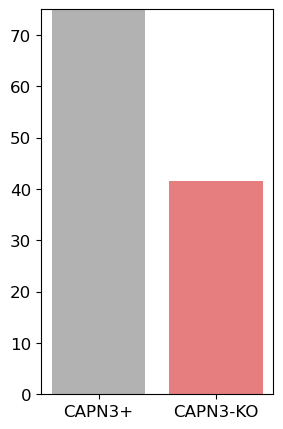

In [222]:
cmap = matplotlib.cm.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

# plt.subplots_adjust(right=0.8)

# ax.bar(["CAPN3+", "CAPN3-KO"], [14.6, 14.6], color=[cmap(7), cmap(3)], alpha=0.6)
# ax.bar(["CAPN3+", "CAPN3-KO"], [36.52, 33.52], color=[cmap(7), cmap(3)], alpha=0.6)
# ax.bar(["CAPN3+", "CAPN3-KO"], [54.8, 38.14], color=[cmap(7), cmap(3)], alpha=0.6)
ax.bar(["CAPN3+", "CAPN3-KO"], [75, 41.56], color=[cmap(7), cmap(3)], alpha=0.6)


# fig.legend(handles=leg)
# ax.set_xlabel("Modèle", fontsize=13)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 75)
# ax.set_ylabel("ATP production flux", fontsize=13)
# plt.title("100% de VO2max", fontsize=15)

### Key fluxes

In [223]:
key_reactions_calpain = create_df_key_fluxes({'calpain_25': solution25_calpain, 'calpain_65': solution65_calpain, 'calpain_85': solution85_calpain, 'calpain_100': solution100_calpain})
key_reactions_calpain

,calpain_25,calpain_65,calpain_85,calpain_100
FBA,0.030000,0.130000,0.600000,2.000000
PDHm,0.033505,0.428000,1.347333,3.133972
LDH_L,-0.075000,-0.104000,-0.141167,-1.131528
CSm,1.228853,2.349378,3.268711,3.342275
r0722,0.100000,0.188810,0.188810,0.016288
r0732,0.100000,0.188810,0.188810,0.016288
OF_ATP_MitoCore,14.600000,33.529094,38.148828,41.560436
O2t,3.460410,6.769272,9.451272,10.139036


In [224]:
print(key_reactions_calpain.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  calpain\_25 &  calpain\_65 &  calpain\_85 &  calpain\_100 \\
\midrule
FBA             &    0.030000 &    0.130000 &    0.600000 &     2.000000 \\
PDHm            &    0.033505 &    0.428000 &    1.347333 &     3.133972 \\
LDH\_L           &   -0.075000 &   -0.104000 &   -0.141167 &    -1.131528 \\
CSm             &    1.228853 &    2.349378 &    3.268711 &     3.342275 \\
r0722           &    0.100000 &    0.188810 &    0.188810 &     0.016288 \\
r0732           &    0.100000 &    0.188810 &    0.188810 &     0.016288 \\
OF\_ATP\_MitoCore &   14.600000 &   33.529094 &   38.148828 &    41.560436 \\
O2t             &    3.460410 &    6.769272 &    9.451272 &    10.139036 \\
\bottomrule
\end{tabular}



C:\Users\home\AppData\Local\Temp\ipykernel_16648\3819918644.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [225]:
dict_results_calpain_voie_metabolique=dict()
dict_results_calpain_accoa=dict()

### Building dataframes

#### Dataframes for treemaps

In [226]:
dt25_calpain = build_dataframe(mitocore_mouse25_calpain, solution25_calpain, 0, 18)
dt65_calpain = build_dataframe(mitocore_mouse65_calpain, solution65_calpain, 0, 18)
dt85_calpain = build_dataframe(mitocore_mouse85_calpain, solution85_calpain, 0, 18)

#### Dataframes of all fluxes

In [227]:
all_fluxes_100_calpain = build_dataframe_visual(mitocore_mouse100_calpain, solution100_calpain)

In [228]:
all_fluxes_25_calpain = build_dataframe_visual(mitocore_mouse25_calpain, solution25_calpain)
print(all_fluxes_25.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [229]:
all_fluxes_65_calpain = build_dataframe_visual(mitocore_mouse65_calpain, solution65_calpain)
print(all_fluxes_65.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

In [230]:
all_fluxes_85_calpain = build_dataframe_visual(mitocore_mouse85_calpain, solution85_calpain)
print(all_fluxes_85.to_markdown())

|                          |        fluxes |   reduced_costs | Subsystems                                                       | Reactions                |
|:-------------------------|--------------:|----------------:|:-----------------------------------------------------------------|:-------------------------|
| ACOAHi                   |   0           |               0 | Acetate production                                               | ACOAHi                   |
| ALCD2yf                  |   0           |               0 | Alcohol metabolism                                               | ALCD2yf                  |
| ALCD2if                  |   0           |               0 | Alcohol metabolism                                               | ALCD2if                  |
| ACALDtm                  |   0           |               0 | Alcohol metabolism                                               | ACALDtm                  |
| ALDD2xm                  |   0           |              

### Flux Variability Analysis

In [231]:
fva25_calpain = output25_calpain[5]
fva65_calpain = output65_calpain[5]
fva85_calpain = output85_calpain[5]
fva100_calpain = output100_calpain[5]

In [232]:
# alternative25_calpain = get_alternative_pathways(fva25_calpain)
# alternative65_calpain = get_alternative_pathways(fva65_calpain)
# alternative85_calpain = get_alternative_pathways(fva85_calpain)

In [233]:
# reaction_to_check_25_calpain = get_reactions_to_check(all_fluxes_25_calpain, alternative25_calpain, 'FA metabolism')
# reaction_to_check_65_calpain = get_reactions_to_check(all_fluxes_65_calpain, alternative65_calpain, 'FA metabolism')
# reaction_to_check_85_calpain = get_reactions_to_check(all_fluxes_85_calpain, alternative85_calpain, 'FA metabolism')

### Building treemaps

In [234]:
display_treemap(dt25_calpain, 'calpain 25')
display_treemap(dt65_calpain, 'calpain 65')
display_treemap(dt85_calpain, 'calpain 85')

### Relative contributions of pathways during exercise

In [235]:
# dict_results_calpain_voie_metabolique["25"]=solution_25_calpainopathy[1]
# dict_results_calpain_voie_metabolique["65"]=solution_65_calpainopathy[1]
# dict_results_calpain_voie_metabolique["85"]=solution_85_calpainopathy[1]
# Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_calpain_voie_metabolique,"plot_mouse_calpain_voie_metabolique.png")

{'glycolysis': 0.06999999999999999, 'beta oxydation': 0.1, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
{'glycolysis': 0.27, 'beta oxydation': 0.188810092218334, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
{'glycolysis': 1.21, 'beta oxydation': 0.188810092218334, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
{'glycolysis': 4.01, 'beta oxydation': 0.01628786052816141, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.002}
['25%' '65%' '85%' '100%']


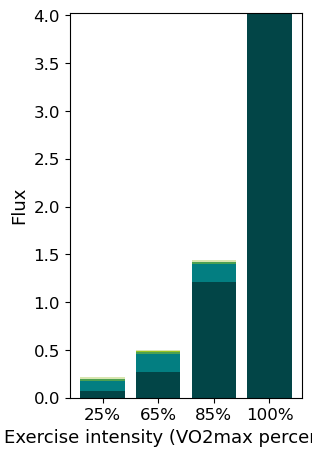

{'25%': {'glycolysis': 0.06999999999999999,
  'beta oxydation': 0.1,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002},
 '65%': {'glycolysis': 0.27,
  'beta oxydation': 0.188810092218334,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002},
 '85%': {'glycolysis': 1.21,
  'beta oxydation': 0.188810092218334,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002},
 '100%': {'glycolysis': 4.01,
  'beta oxydation': 0.01628786052816141,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.002}}

In [236]:
dict_results_calpain_voie_metabolique["25%"]=output25_calpain[1]
dict_results_calpain_voie_metabolique["65%"]=output65_calpain[1]
dict_results_calpain_voie_metabolique["85%"]=output85_calpain[1]
dict_results_calpain_voie_metabolique["100%"]=output100_calpain[1]
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_calpain_voie_metabolique,"plot_mouse_calpain_voie_metabolique_add.png")

In [237]:
dict_results_voie_metabolique_proportion_calpain = build_dict_proportion(dict_pathway=dict_results_calpain_voie_metabolique, dict_tot={'25%':0,'65%':0,'85%':0, '100%':0}, dict_prop={'25%':{},'65%':{},'85%':{}, '100%':{}})

{'glycolysis': 0.33018867924528306, 'beta oxydation': 0.4716981132075473, 'ketone bodies': 0.11320754716981134, 'leucine degradation': 0.07547169811320756, 'isoleucine degradation': 0.009433962264150945}
{'glycolysis': 0.5391265156100136, 'beta oxydation': 0.3770093597395398, 'ketone bodies': 0.04792235694311232, 'leucine degradation': 0.031948237962074875, 'isoleucine degradation': 0.0039935297452593594}
{'glycolysis': 0.8398053334961245, 'beta oxydation': 0.13104439872962978, 'ketone bodies': 0.016657295870997513, 'leucine degradation': 0.011104863913998342, 'isoleucine degradation': 0.0013881079892497927}
{'glycolysis': 0.9954601405953735, 'beta oxydation': 0.004043370556449225, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.0004964888481772437}
['25%' '65%' '85%' '100%']


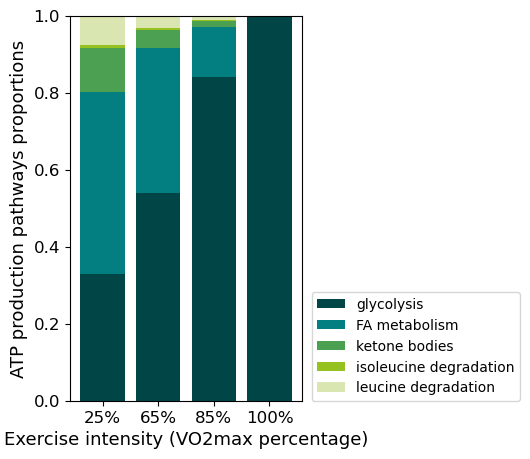

{'25%': {'glycolysis': 0.33018867924528306,
  'beta oxydation': 0.4716981132075473,
  'ketone bodies': 0.11320754716981134,
  'leucine degradation': 0.07547169811320756,
  'isoleucine degradation': 0.009433962264150945},
 '65%': {'glycolysis': 0.5391265156100136,
  'beta oxydation': 0.3770093597395398,
  'ketone bodies': 0.04792235694311232,
  'leucine degradation': 0.031948237962074875,
  'isoleucine degradation': 0.0039935297452593594},
 '85%': {'glycolysis': 0.8398053334961245,
  'beta oxydation': 0.13104439872962978,
  'ketone bodies': 0.016657295870997513,
  'leucine degradation': 0.011104863913998342,
  'isoleucine degradation': 0.0013881079892497927},
 '100%': {'glycolysis': 0.9954601405953735,
  'beta oxydation': 0.004043370556449225,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.0004964888481772437}}

In [238]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_voie_metabolique_proportion_calpain,"plot_mouse_voie_metabolique_proportion_calpain_add.png", prop=True)

In [239]:
key_reactions_calpain_plot = key_reactions_calpain.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

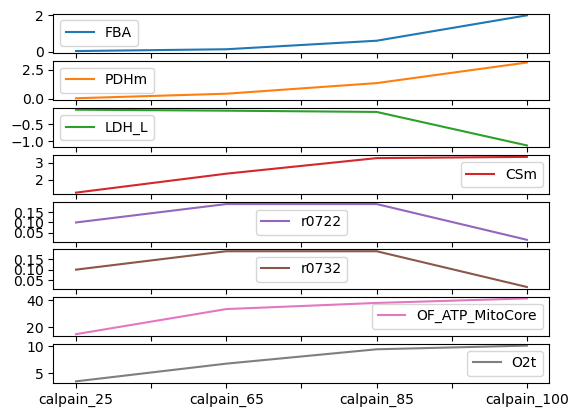

In [240]:
key_reactions_calpain_plot.plot(subplots=True)

In [241]:
df_plot_calpain = create_flux_plot({'calpain_25': [solution25_calpain, fva25_calpain], 'calpain_65': [solution65_calpain, fva65_calpain], 'calpain_85': [solution85_calpain, fva85_calpain], 'calpain_100': [solution100_calpain, fva100_calpain]})

C:\Users\home\AppData\Local\Temp\ipykernel_16648\3911538967.py:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



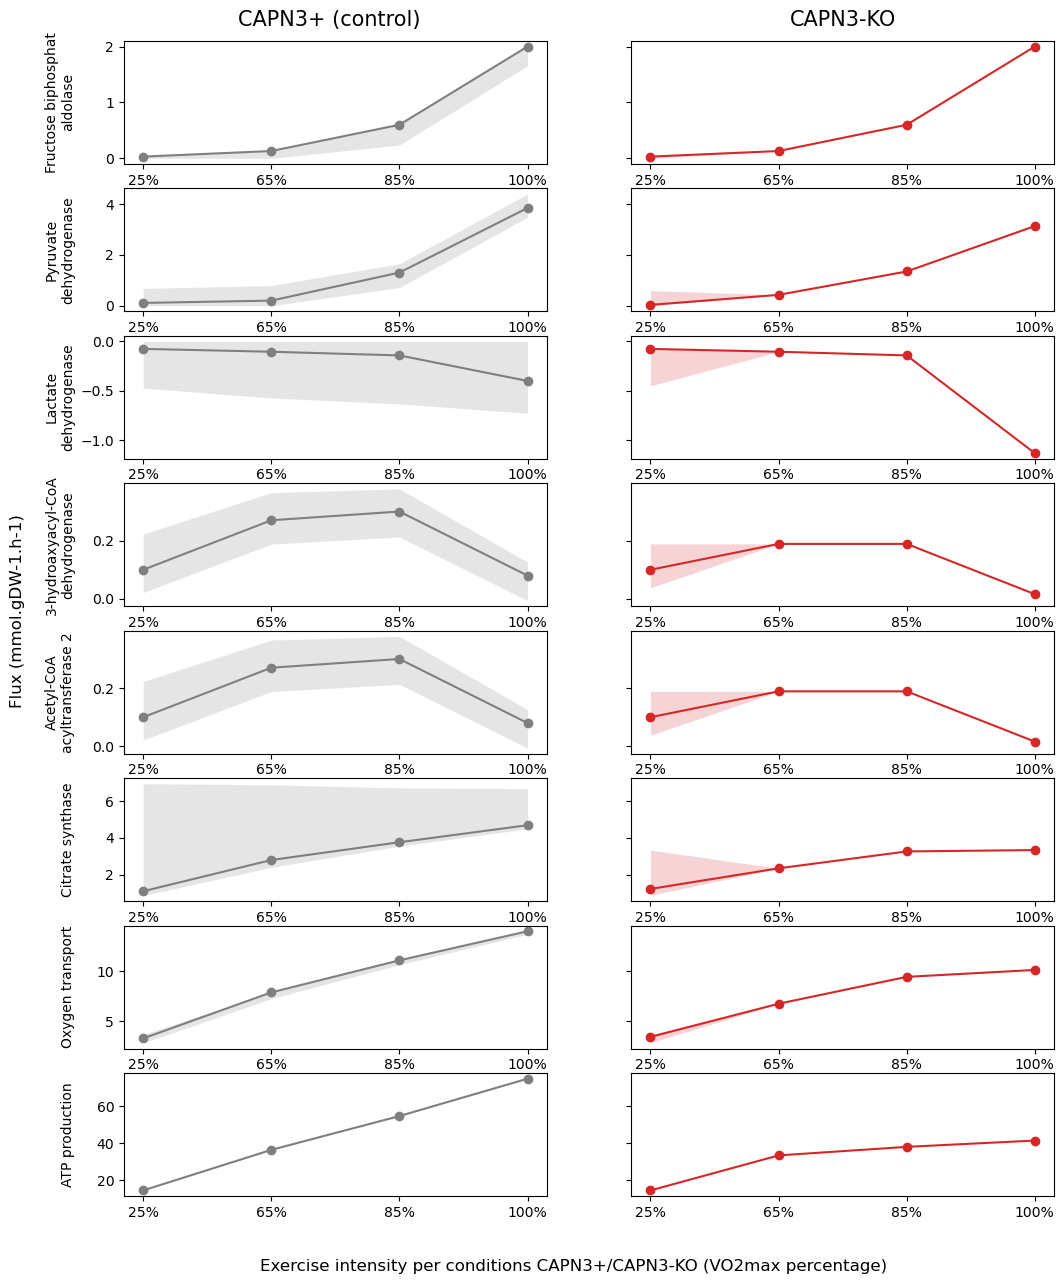

In [242]:
cmap = matplotlib.cm.get_cmap('tab10')
# markers = ["o", "^", "s", "P", "x", "*", "h", "d"]
count = 0
# leg = []
list_enzyme = ["FBA", "PDHm", "LDH_L", "r0722", "r0732", "CSm", "O2t", "OF_ATP_MitoCore"]
legend = {"FBA": "Fructose biphosphat\naldolase", "PDHm": "Pyruvate\ndehydrogenase", "LDH_L": "Lactate\ndehydrogenase", "r0722": "3-hydroaxyacyl-CoA\ndehydrogenase", "r0732": "Acetyl-CoA\nacyltransferase 2", "CSm": "Citrate synthase", "O2t": "Oxygen transport", "OF_ATP_MitoCore": "ATP production"}

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16)) = plt.subplots(8, 2, figsize=(12, 15), sharey='row')
axes = [(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16)]


# plt.subplots_adjust(right=0.8)
# plt.margins(x=0, y=0)
for enzyme in list_enzyme:
    df_enz = df_plot_calpain.loc[df_plot_calpain['enzymes'] == enzyme]
    df_enz_wt = df_wt_plot.loc[df_wt_plot['enzymes'] == enzyme]

    # y = 0.85-(0.1*count)
    # print(y)
    # fig.text(0.1, y, enzyme, fontsize=12)

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 1.5), sharey=True)
    axes[count][0].scatter(df_enz_wt['intensity'], df_enz_wt['fluxes'], color=cmap(7))
    axes[count][0].plot(df_enz_wt['intensity'], df_enz_wt['fluxes'], color=cmap(7))
    axes[count][0].fill_between(df_enz_wt['intensity'], df_enz_wt['fva_min'], df_enz_wt['fva_max'], alpha=0.2, color=cmap(7), linewidth=0)
    axes[count][0].set_ylabel(legend[enzyme], fontsize=10)


    axes[count][1].scatter(df_enz['intensity'], df_enz['fluxes'], color=cmap(3))
    axes[count][1].plot(df_enz['intensity'], df_enz['fluxes'], color=cmap(3))
    axes[count][1].fill_between(df_enz['intensity'], df_enz['fva_min'], df_enz['fva_max'], alpha=0.2, color=cmap(3), linewidth=0)

    # leg.append(mlines.Line2D([], [], color=cmap(count), marker=markers[count], markersize=10, label=enzyme, ls='-'))
    # fig.legend(handles=[leg])
    count += 1

# fig.legend(handles=leg, loc="center right")
# fig.tight_layout()
fig.align_ylabels()
fig.text(0.22, 0.89, "CAPN3+ (control)", fontsize=15)
fig.text(0.68, 0.89, "CAPN3-KO", fontsize=15)
fig.text(0.5, 0.06, "Exercise intensity per conditions CAPN3+/CAPN3-KO (VO2max percentage)", ha='center', fontsize=12)
fig.text(0.03, 0.5, 'Flux (mmol.gDW-1.h-1)', va='center', rotation='vertical', fontsize=12)
fig.savefig("Plots/FVA_wt_calpain.png")

####  Pourquoi les ketones bodies apparaissent dans dans la production d'acetyl coa mais pas dans la voie métabolique des ketone bodies :
La voie "ketone bodies" de production d'acetyl coa est en fait la voie "FA and ketone body metabolism / Ketogenesis" et inclut donc la le métabolisme lipidique

cela n'explique pour autant pas tout car la voie métabolique des lipides n'est pas détéctée.

In [243]:
# dict_results_calpain_accoa["25"]=solution_25_calpainopathy[0]
# dict_results_calpain_accoa["65"]=solution_65_calpainopathy[0]
# dict_results_calpain_accoa["85"]=solution_85_calpainopathy[0]
# print(dict_results_calpain_accoa)
# Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_results_calpain_accoa,"plot_mouse_calpain_accoa.png",accoa=True)

In [244]:
######## A FAIRE : COMPARAISON FLUX PAR FLUX

,25calpain,65calpain,85calpain
EX_biomass_e,14.600000,33.529094,38.148828
EX_co2_e,2.614737,5.584652,8.260152
EX_lac_L_e,0.075000,0.104000,0.141167
EX_nh4_e,0.346347,0.366897,0.361897
EX_oaa_e,0.159000,0.000000,0.000000
...,...,...,...
PROD2mB_MitoCore,0.000000,0.000000,4.418623
P5CRxm,0.000000,0.000000,4.414623
TYRTB_MitoCore,0.000000,0.000000,0.105301
GTHP,0.000000,0.000000,0.128198


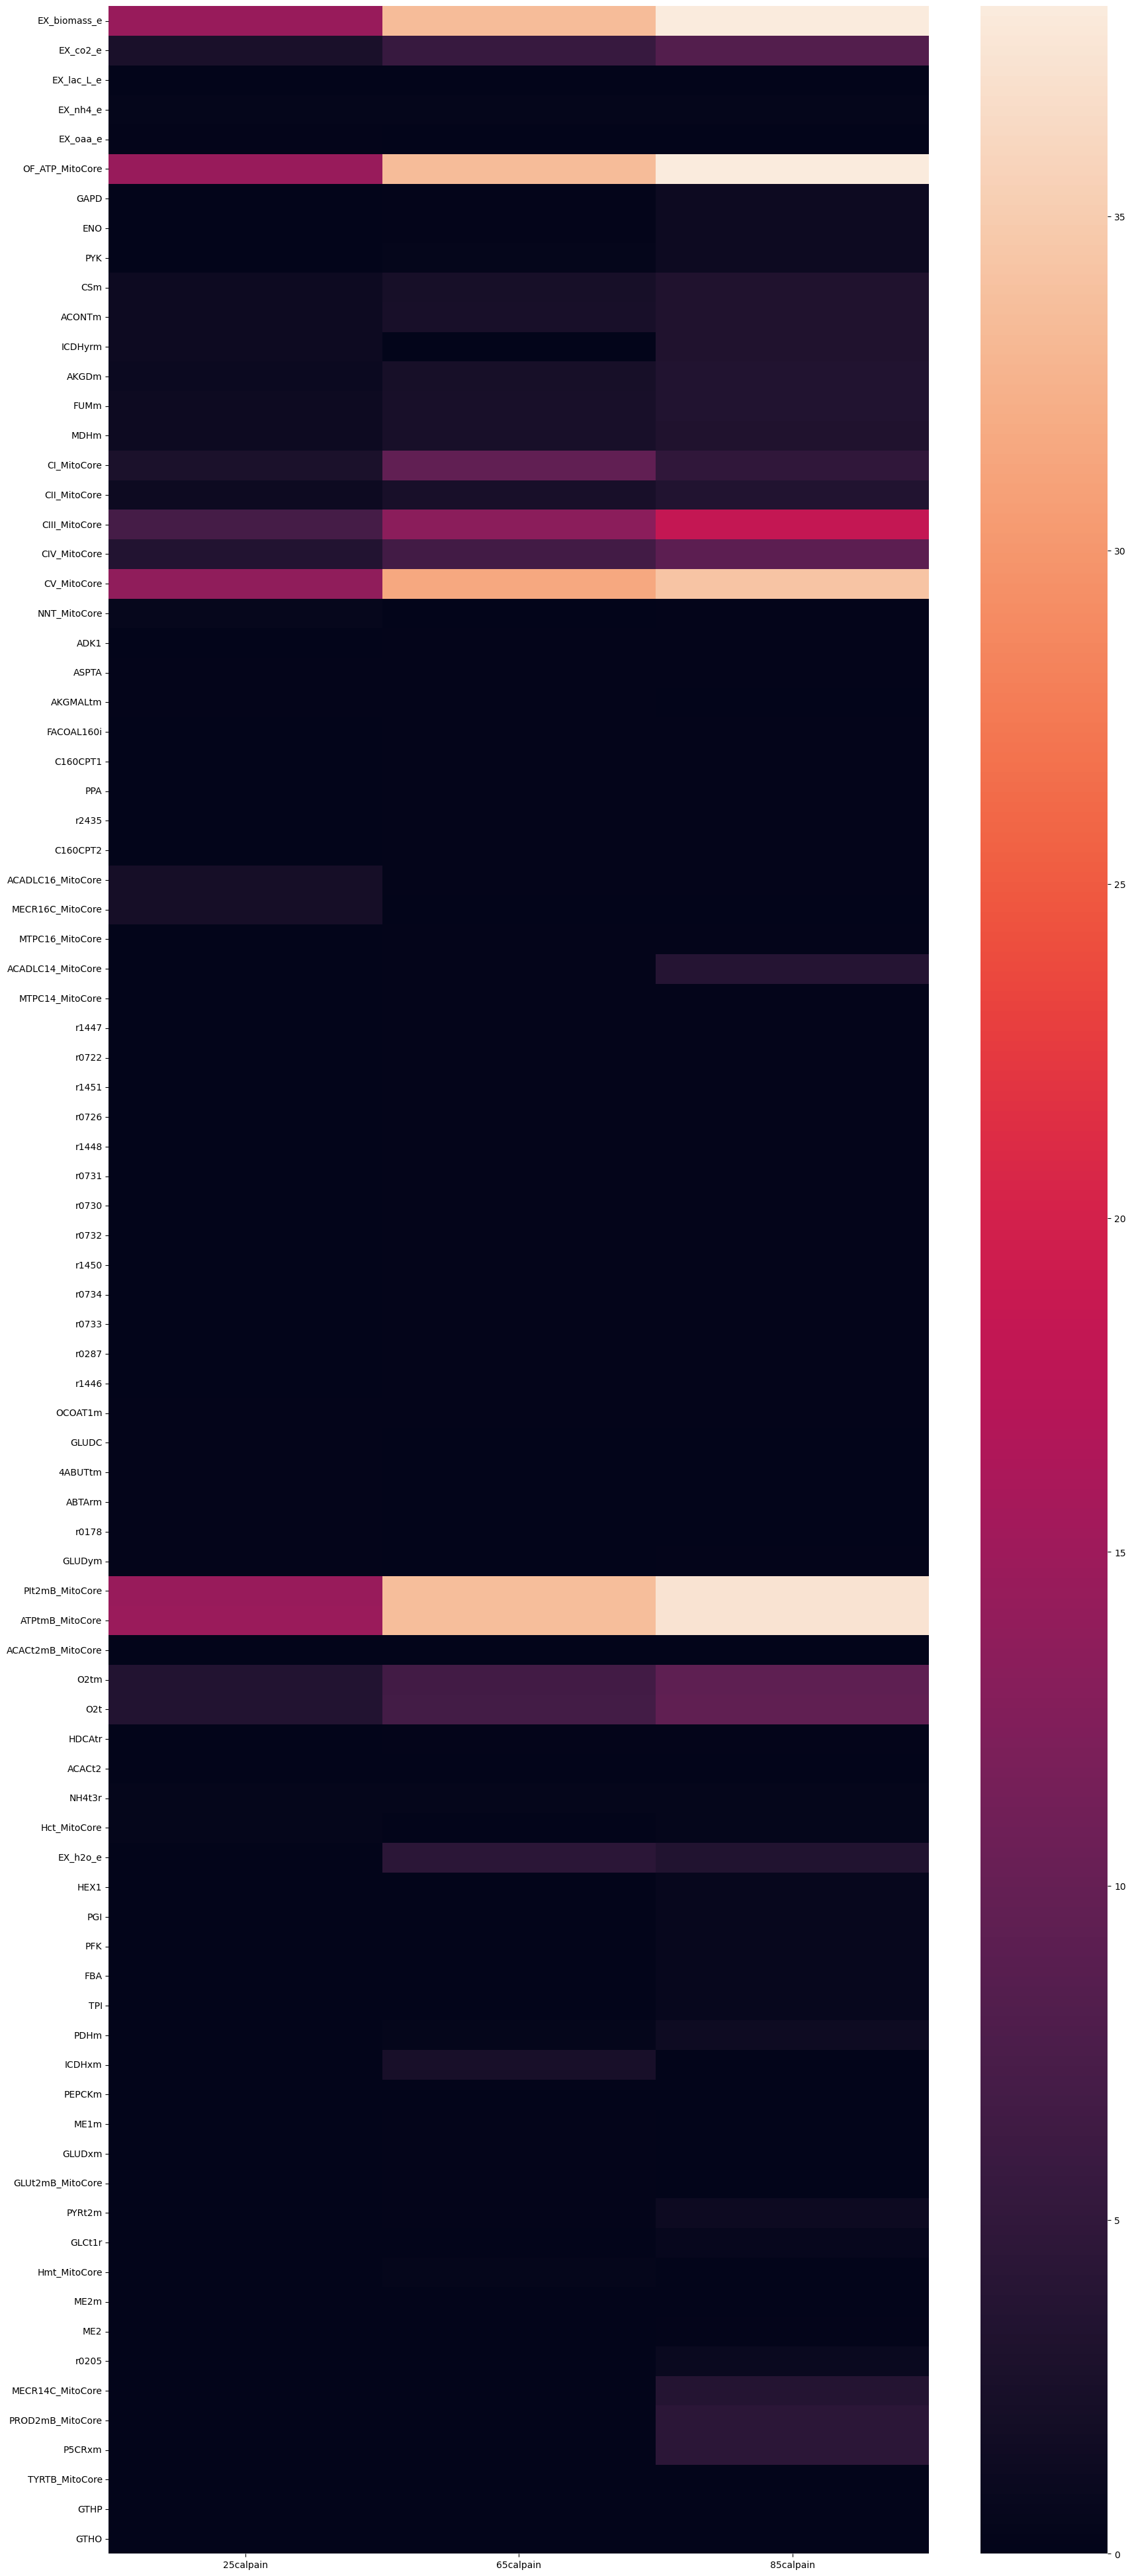

In [245]:
#comparaison des flux entre calpainopathy
Utils_Cobrapy.heatmap_flux(save=True,solutions=[solution25_calpain,solution65_calpain,solution85_calpain]
                          ,name_columns=["25calpain","65calpain","85calpain"],name_plot="Plots/heatmap_flux_calpain.png")


In [246]:
#comparaison des flux entre conditions saines
# Utils_Cobrapy.heatmap_flux(save=True,solutions=[output25[3],output65[3],output85[3]]
#                           ,name_columns=["25","65","85"],name_plot="Plots/heatmap_flux_sain.png")

In [247]:
#comparaison des flux entre conditions saines et malades
# Utils_Cobrapy.heatmap_flux(save=True,name_plot="Plots/heatmap_compare_flux_sain_calpain.png",
#     solutions=[output25[3],solution_25_calpainopathy[3]
#                                       ,output65[3],solution_65_calpainopathy[3]
#                                       ,output85[3],solution_85_calpainopathy[3]]
#                           ,name_columns=["25","calpain25","65","calpain65","85","calpain85"])

# Comparaison

In [248]:
dict_comparaison_voies_25=dict()
dict_comparaison_voies_65=dict()
dict_comparaison_voies_85=dict()
dict_comparaison_voies_100=dict()

In [249]:
pathways = ["Objective Function - ATP", "FA metabolism", 'Glycolysis', "Glycolysis/gluconeogenesis", "TCA cycle", "Boundary conditions - core", "Isoleucine degradation", "Leucine degradation"]
pathways2 = ["FA metabolism", 'Glycolysis', "Glycolysis/gluconeogenesis", "TCA cycle", "Boundary conditions - core", "Isoleucine degradation", "Leucine degradation"]

In [250]:
dt25 = build_dataframe(mitocore_mouse25, solution25, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt65 = build_dataframe(mitocore_mouse65, solution65, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt85 = build_dataframe(mitocore_mouse85, solution85, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt100 = build_dataframe(mitocore_mouse100, solution100, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt25_calpain = build_dataframe(mitocore_mouse25_calpain, solution25_calpain, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt65_calpain = build_dataframe(mitocore_mouse65_calpain, solution65_calpain, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt85_calpain = build_dataframe(mitocore_mouse85_calpain, solution85_calpain, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)
dt100_calpain = build_dataframe(mitocore_mouse100_calpain, solution100_calpain, 0, 180, hide_transport=False, from_list=True, pathways_list=pathways2)

## 25% d'intensité

In [251]:
dict_comparaison_voies_25['CAPN3+'] = dict_results_voie_metabolique["25%"]
dict_comparaison_voies_25['CAPN3-KO'] = dict_results_calpain_voie_metabolique["25%"]

{'glycolysis': 0.06999999999999972, 'beta oxydation': 0.1, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.004}
{'glycolysis': 0.06999999999999999, 'beta oxydation': 0.1, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
['CAPN3+' 'CAPN3-KO']


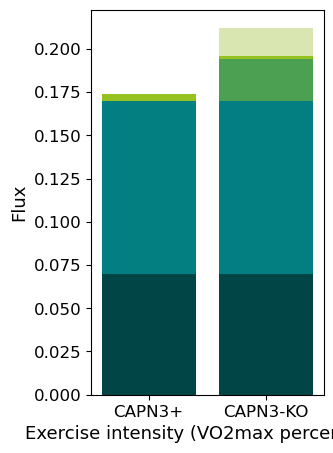

{'CAPN3+': {'glycolysis': 0.06999999999999972,
  'beta oxydation': 0.1,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.004},
 'CAPN3-KO': {'glycolysis': 0.06999999999999999,
  'beta oxydation': 0.1,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002}}

In [252]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_comparaison_voies_25,"plot_comparaison_wt_vs_calpain_25.png")

{'glycolysis': 0.40229885057471165, 'beta oxydation': 0.5747126436781619, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.022988505747126475}
{'glycolysis': 0.33018867924528306, 'beta oxydation': 0.4716981132075473, 'ketone bodies': 0.11320754716981134, 'leucine degradation': 0.07547169811320756, 'isoleucine degradation': 0.009433962264150945}
['CAPN3+' 'CAPN3-KO']


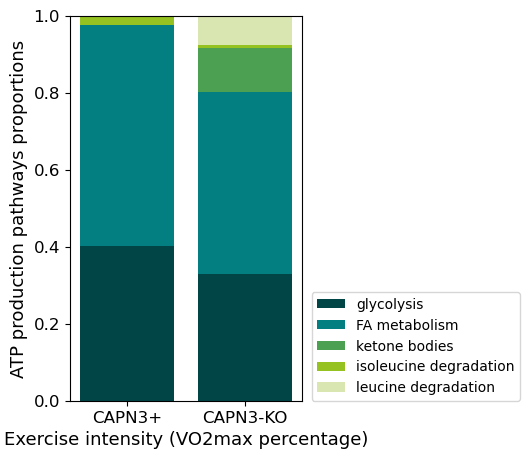

{'CAPN3+': {'glycolysis': 0.40229885057471165,
  'beta oxydation': 0.5747126436781619,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.022988505747126475},
 'CAPN3-KO': {'glycolysis': 0.33018867924528306,
  'beta oxydation': 0.4716981132075473,
  'ketone bodies': 0.11320754716981134,
  'leucine degradation': 0.07547169811320756,
  'isoleucine degradation': 0.009433962264150945}}

In [253]:
proportion_wt_calpain_25 = build_dict_proportion(dict_pathway=dict_comparaison_voies_25, dict_tot={'CAPN3+':0,'CAPN3-KO':0}, dict_prop={'CAPN3+':{},'CAPN3-KO':{}})
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(proportion_wt_calpain_25,"plot_proportion_wt_calpain_25.png", prop=True)

In [254]:
display_treemap(dt25, 'wt 25')
display_treemap(dt25_calpain, 'calpain 25')

## 65% d'intensité

In [255]:
dict_comparaison_voies_65['CAPN3+'] = dict_results_voie_metabolique["65%"]
dict_comparaison_voies_65['CAPN3-KO'] = dict_results_calpain_voie_metabolique["65%"]

{'glycolysis': 0.27, 'beta oxydation': 0.27, 'ketone bodies': 0.048, 'leucine degradation': 0.016, 'isoleucine degradation': 0.004}
{'glycolysis': 0.27, 'beta oxydation': 0.188810092218334, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
['CAPN3+' 'CAPN3-KO']


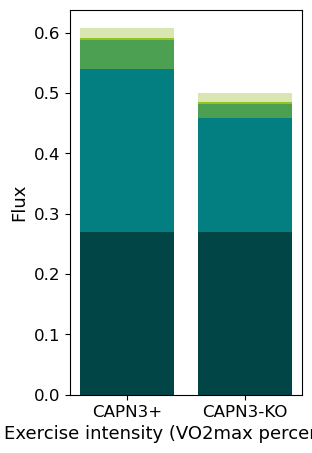

{'CAPN3+': {'glycolysis': 0.27,
  'beta oxydation': 0.27,
  'ketone bodies': 0.048,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.004},
 'CAPN3-KO': {'glycolysis': 0.27,
  'beta oxydation': 0.188810092218334,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002}}

In [256]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_comparaison_voies_65,"plot_comparaison_wt_vs_calpain_65.png")

In [257]:
#sum(proportion_wt_calpain_65['CAPN3+'].values())

{'glycolysis': 0.444078947368421, 'beta oxydation': 0.444078947368421, 'ketone bodies': 0.07894736842105263, 'leucine degradation': 0.026315789473684206, 'isoleucine degradation': 0.006578947368421051}
{'glycolysis': 0.5391265156100136, 'beta oxydation': 0.3770093597395398, 'ketone bodies': 0.04792235694311232, 'leucine degradation': 0.031948237962074875, 'isoleucine degradation': 0.0039935297452593594}
['CAPN3+' 'CAPN3-KO']


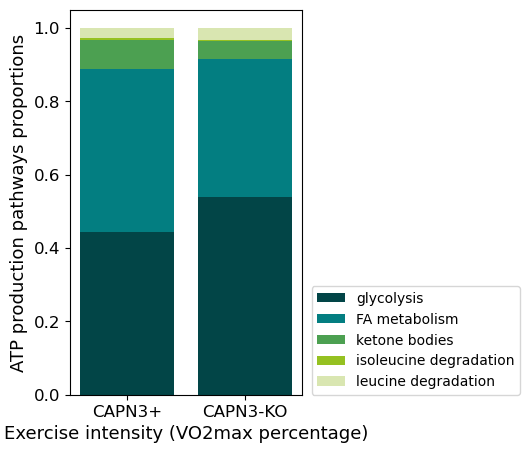

{'CAPN3+': {'glycolysis': 0.444078947368421,
  'beta oxydation': 0.444078947368421,
  'ketone bodies': 0.07894736842105263,
  'leucine degradation': 0.026315789473684206,
  'isoleucine degradation': 0.006578947368421051},
 'CAPN3-KO': {'glycolysis': 0.5391265156100136,
  'beta oxydation': 0.3770093597395398,
  'ketone bodies': 0.04792235694311232,
  'leucine degradation': 0.031948237962074875,
  'isoleucine degradation': 0.0039935297452593594}}

In [258]:
proportion_wt_calpain_65 = build_dict_proportion(dict_pathway=dict_comparaison_voies_65, dict_tot={'CAPN3+':0,'CAPN3-KO':0}, dict_prop={'CAPN3+':{},'CAPN3-KO':{}})
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(proportion_wt_calpain_65,"plot_proportion_wt_calpain_65.png", prop=True)

In [259]:
0.444078947368421+0.444078947368421+0.07894736842105263+0.026315789473684206+0.006578947368421051

0.9999999999999999

In [260]:
display_treemap(dt65, 'wt 65')
display_treemap(dt65_calpain, 'calpain 65')

## 85% d'intensité

In [261]:
dict_comparaison_voies_85['CAPN3+'] = dict_results_voie_metabolique["85%"]
dict_comparaison_voies_85['CAPN3-KO'] = dict_results_calpain_voie_metabolique["85%"]

{'glycolysis': 1.21, 'beta oxydation': 0.3, 'ketone bodies': 0.0, 'leucine degradation': 3.885780586188048e-16, 'isoleucine degradation': 0.004}
{'glycolysis': 1.21, 'beta oxydation': 0.188810092218334, 'ketone bodies': 0.024, 'leucine degradation': 0.016, 'isoleucine degradation': 0.002}
['CAPN3+' 'CAPN3-KO']


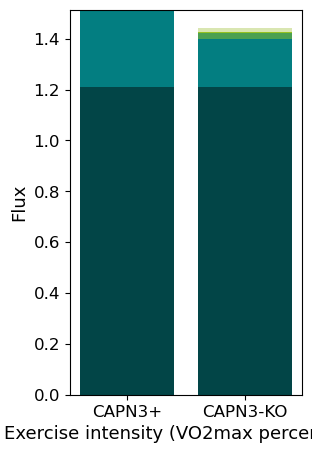

{'CAPN3+': {'glycolysis': 1.21,
  'beta oxydation': 0.3,
  'ketone bodies': 0.0,
  'leucine degradation': 3.885780586188048e-16,
  'isoleucine degradation': 0.004},
 'CAPN3-KO': {'glycolysis': 1.21,
  'beta oxydation': 0.188810092218334,
  'ketone bodies': 0.024,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.002}}

In [262]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_comparaison_voies_85,"plot_comparaison_wt_vs_calpain_85.png")

{'glycolysis': 0.7992073976221926, 'beta oxydation': 0.1981505944517833, 'ketone bodies': 0.0, 'leucine degradation': 2.5665657768745355e-16, 'isoleucine degradation': 0.0026420079260237772}
{'glycolysis': 0.8398053334961245, 'beta oxydation': 0.13104439872962978, 'ketone bodies': 0.016657295870997513, 'leucine degradation': 0.011104863913998342, 'isoleucine degradation': 0.0013881079892497927}
['CAPN3+' 'CAPN3-KO']


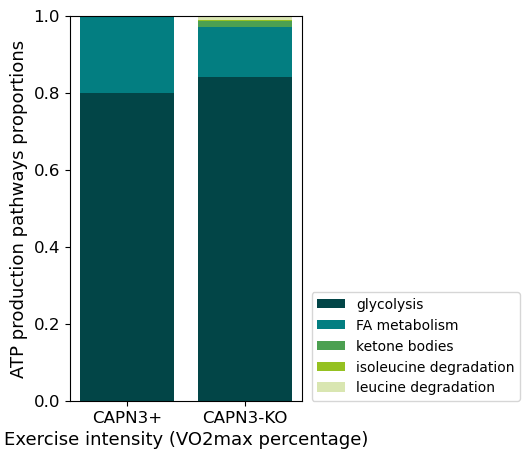

{'CAPN3+': {'glycolysis': 0.7992073976221926,
  'beta oxydation': 0.1981505944517833,
  'ketone bodies': 0.0,
  'leucine degradation': 2.5665657768745355e-16,
  'isoleucine degradation': 0.0026420079260237772},
 'CAPN3-KO': {'glycolysis': 0.8398053334961245,
  'beta oxydation': 0.13104439872962978,
  'ketone bodies': 0.016657295870997513,
  'leucine degradation': 0.011104863913998342,
  'isoleucine degradation': 0.0013881079892497927}}

In [263]:
proportion_wt_calpain_85 = build_dict_proportion(dict_pathway=dict_comparaison_voies_85, dict_tot={'CAPN3+':0,'CAPN3-KO':0}, dict_prop={'CAPN3+':{},'CAPN3-KO':{}})
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(proportion_wt_calpain_85,"plot_proportion_wt_calpain_85.png", prop=True)

In [264]:
display_treemap(dt85, 'wt 85')
display_treemap(dt85_calpain, 'calpain 85')

## 100% d'intensité

In [265]:
dict_comparaison_voies_100['CAPN3+'] = output100[1]
dict_comparaison_voies_100['CAPN3-KO'] = output100_calpain[1]

{'glycolysis': 4.01, 'beta oxydation': 0.08, 'ketone bodies': 0.048, 'leucine degradation': 0.016, 'isoleucine degradation': 0.004}
{'glycolysis': 4.01, 'beta oxydation': 0.01628786052816141, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.002}
['CAPN3+' 'CAPN3-KO']


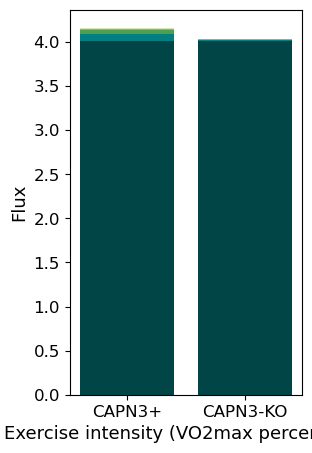

{'CAPN3+': {'glycolysis': 4.01,
  'beta oxydation': 0.08,
  'ketone bodies': 0.048,
  'leucine degradation': 0.016,
  'isoleucine degradation': 0.004},
 'CAPN3-KO': {'glycolysis': 4.01,
  'beta oxydation': 0.01628786052816141,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.002}}

In [266]:
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(dict_comparaison_voies_100,"plot_comparaison_wt_vs_calpain_100.png")

{'glycolysis': 0.9644059644059645, 'beta oxydation': 0.01924001924001924, 'ketone bodies': 0.011544011544011546, 'leucine degradation': 0.0038480038480038486, 'isoleucine degradation': 0.0009620009620009621}
{'glycolysis': 0.9954601405953735, 'beta oxydation': 0.004043370556449225, 'ketone bodies': 0.0, 'leucine degradation': 0.0, 'isoleucine degradation': 0.0004964888481772437}
['CAPN3+' 'CAPN3-KO']


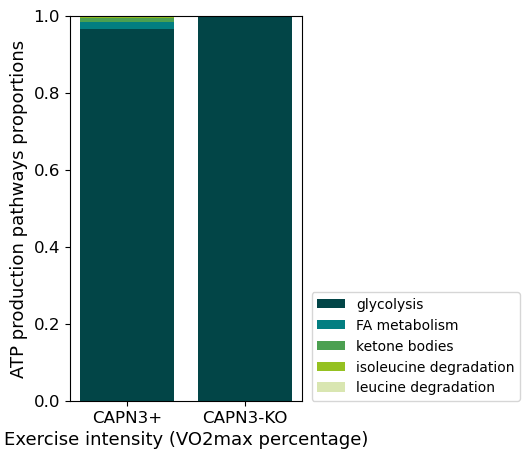

{'CAPN3+': {'glycolysis': 0.9644059644059645,
  'beta oxydation': 0.01924001924001924,
  'ketone bodies': 0.011544011544011546,
  'leucine degradation': 0.0038480038480038486,
  'isoleucine degradation': 0.0009620009620009621},
 'CAPN3-KO': {'glycolysis': 0.9954601405953735,
  'beta oxydation': 0.004043370556449225,
  'ketone bodies': 0.0,
  'leucine degradation': 0.0,
  'isoleucine degradation': 0.0004964888481772437}}

In [267]:
proportion_wt_calpain_100 = build_dict_proportion(dict_pathway=dict_comparaison_voies_100, dict_tot={'CAPN3+':0,'CAPN3-KO':0}, dict_prop={'CAPN3+':{},'CAPN3-KO':{}})
Utils_Cobrapy.plot_voie_metabolique_ou_accoa(proportion_wt_calpain_100,"plot_proportion_wt_calpain_100.png", prop=True)

## Visualisation

### Essaie map escher

In [268]:
builder25 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse25_calpain, reaction_data=solution25_calpain.fluxes)
builder25.height = 800
builder25

Builder(height=800, reaction_data={'EX_2hb_e': 0.0, 'EX_ac_e': 0.0, 'EX_acac_e': -0.114, 'EX_akg_e': 0.0, 'EX_…

In [269]:
builder25 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse25, reaction_data=solution25.fluxes)
builder25.height = 800
builder25

Builder(height=800, reaction_data={'EX_2hb_e': 0.0, 'EX_ac_e': 0.0, 'EX_acac_e': -0.03403915229885011, 'EX_akg…

In [270]:
builder65 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse65_calpain, reaction_data=solution65_calpain.fluxes)
builder65.height = 800
builder65

Builder(height=800, reaction_data={'EX_2hb_e': 0.0, 'EX_ac_e': 0.0, 'EX_acac_e': -0.114, 'EX_akg_e': 0.0, 'EX_…

In [271]:
builder85 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse85_calpain, reaction_data=solution85_calpain.fluxes)
builder85.height = 800
builder85

Builder(height=800, reaction_data={'EX_2hb_e': 0.0, 'EX_ac_e': 0.0, 'EX_acac_e': -0.114, 'EX_akg_e': 0.0, 'EX_…

In [272]:
builder100 = Builder(map_json="./Models/RECON1.Glycolysis TCA PPP.json", model=mitocore_mouse100_calpain, reaction_data=solution100_calpain.fluxes)
builder100.height = 800
builder100

Builder(height=800, reaction_data={'EX_2hb_e': 0.0, 'EX_ac_e': 0.0, 'EX_acac_e': 0.0, 'EX_akg_e': 0.0, 'EX_ala…

### Reactions/Metabolites

In [273]:
print(mitocore_mouse25.reactions.OF_ATP_MitoCore)


OF_ATP_MitoCore: atp_c + h2o_c --> adp_c + biomass_c + h_c + pi_c


In [274]:
print_reactions_from_met(mitocore_mouse25_calpain, 'gdp_c', solution25_calpain)

In [275]:
print_reactions_from_met(mitocore_mouse25, 'gdp_c', solution25)

PEPCK: gtp_c + oaa_c --> co2_c + gdp_c + pep_c
fluxes           0.0975
reduced_costs    0.0000
Name: PEPCK, dtype: float64
--------
r0122: gdp_c + h_c + pep_c --> gtp_c + pyr_c
fluxes           0.0975
reduced_costs    0.0000
Name: r0122, dtype: float64
--------


In [276]:
get_reactions_from_subsys(mitocore_mouse85, all_fluxes_85, ["TCA cycle", "TCA cycle periphery", "Electron transport chain CI", "Electron transport chain CII", 
                                                          "Electron transport chain CIII", "Electron transport chain CIV", "Electron transport chain CV" ])


------ Reactions from TCA cycle -------

SUCOASm: atp_m + coa_m + succ_m <=> adp_m + pi_m + succoa_m
-3.8048333333333337

SUCOAS1m: coa_m + gtp_m + succ_m <=> gdp_m + pi_m + succoa_m
0.0

ICDHyrm: icit_m + nadp_m <=> akg_m + co2_m + nadph_m
0.571245983935746

PDHm: coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
1.3048333333333335

ICDHxm: icit_m + nad_m --> akg_m + co2_m + nadh_m
3.1975873493975877

CSm: accoa_m + h2o_m + oaa_m --> cit_m + coa_m + h_m
3.7688333333333337

ACONTm: cit_m <=> icit_m
3.7688333333333337

MDHm: mal_L_m + nad_m <=> h_m + nadh_m + oaa_m
3.7688333333333337

AKGDm: akg_m + coa_m + nad_m --> co2_m + nadh_m + succoa_m
3.7898333333333336

FUMm: fum_m + h2o_m <=> mal_L_m
3.8048333333333337


------ Reactions from TCA cycle periphery -------

PEPCKm: gtp_m + oaa_m --> co2_m + gdp_m + pep_m
0.0

PCm: atp_m + hco3_m + pyr_m --> adp_m + h_m + oaa_m + pi_m
0.0

ME1m: mal_L_m + nad_m --> co2_m + nadh_m + pyr_m
0.0

r0081: akg_m + ala_L_m <=> glu_L_m + pyr_m
0.0

ACITL

In [277]:
print(mitocore_mouse100.groups.get_by_any("Leucine degradation")[0])

Leucine degradation


In [278]:
enz = ["FBA", "PDHm", "LDH_L", "CSm", "r0722", "r0732", "OF_ATP_MitoCore", "O2t"]

for e in enz:
    print(mitocore_mouse25.reactions.get_by_id(e).notes)

{'Model Reaction Number': '10', 'EC Number': '4.1.2.13', 'SUBSYSTEM': 'Glycolysis/gluconeogenesis', 'Description': 'beta-D-Fructose 1,6-bisphosphate --&gt; Glycerone phosphate + D-Glyceraldehyde 3-phosphate', 'Recon2 id': 'FBA', 'Recon2 formula': 'fdp[c] --&gt; dhap[c] + g3p[c]', 'KEGG id': 'R01070', 'GENE_ASSOCIATION': 'ENSG00000149925 or ENSG00000109107', 'GENE_LIST': 'ALDOA or ALDOC', 'HGNC': '414 or HGNC:418', 'Gene name': 'fructose-bisphosphate aldolase', 'MitoCarta': 'FALSE', 'MitoCarta score': '-4.8741', 'HPA mRNA level in heart tissue': 'High or High', 'HPA protein level in heart tissue': 'Not detected or Not detected'}
{'Model Reaction Number': '28', 'EC Number': '1.2.4.1, 2.3.1.12, 1.8.1.4', 'SUBSYSTEM': 'TCA cycle', 'Description': 'Pyruvate + CoA + NAD+ --&gt; Acetyl-CoA + CO2 + NADH + H+', 'Recon2 id': 'PDHm', 'Recon2 formula': 'nad[m] + pyr[m] + coa[m] -&gt; nadh[m] + co2[m] + accoa[m]', 'KEGG id': 'R00209 (R01699 + R02569 + R07618)', 'GENE_ASSOCIATION': 'ENSG00000131828 a